# 연구과제 4. 고객분류

## #1. 패키지 참조

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

from pandas import merge
from scipy.stats import spearmanr
from sklearn.preprocessing import OneHotEncoder

## #2. 데이터 불러오기 및 특성 확인

In [2]:
categories = ['Gender','Ever_Married','Graduated','Profession','Spending_Score','Var_1','Segmentation'] 
origin = my_read_excel('C:/Users/J/Desktop/Data_Science/Class/E.추론통계/E.InferentialStatistics/수업자료/customer_segmentation.xlsx', categories=categories)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ID               10695 non-null  int64   
 1   Gender           10695 non-null  category
 2   Ever_Married     10505 non-null  category
 3   Age              10695 non-null  int64   
 4   Graduated        10593 non-null  category
 5   Profession       10533 non-null  category
 6   Work_Experience  9597 non-null   float64 
 7   Spending_Score   10695 non-null  category
 8   Family_Size      10247 non-null  float64 
 9   Var_1            10587 non-null  category
 10  Segmentation     10695 non-null  category
dtypes: category(7), float64(2), int64(2)
memory usage: 408.9 KB
None

데이터프레임 상위 5개 행
+----+--------+----------+----------------+-------+-------------+---------------+-------------------+------------------+---------------+---------+----------------+
|    |     ID | Gender   | Eve

> - 데이터 분석 목적: 기존 고객데이터를 활용하여 새로운 고객이 어떤 그룹에 속할지 분류하는 모델 만들기
> ---
> - 종속변수: Segmentation, 나머지 독립변수 10개
> - 총 10,695행 11열의 데이터
> - 데이터타입: ID, 나이, 경력, 가족수만 숫자타입, 나머지는 문자열
> - 숫자타입 제외 모두 카테고리 타입으로 변환
> - 성별과, 결혼여부, 졸업여부, 지출점수, 고객분류는 라벨링 필요
> - Null값이 꽤 많이 보이므로 적합한 처리 방법 필요
> - 기술통계에서 경력의 평균과 중간값의 차이가 크므로 적절한 이상치 처리 필요해보인다.  

## #3. 전처리 

### (1) 데이터타입 확인

In [3]:
origin.dtypes

ID                    int64
Gender             category
Ever_Married       category
Age                   int64
Graduated          category
Profession         category
Work_Experience     float64
Spending_Score     category
Family_Size         float64
Var_1              category
Segmentation       category
dtype: object

### (2) 중복행 확인 및 제거

In [4]:
# 중복행 유무 확인
origin.duplicated().sum()

38

In [5]:
# 중복행 제거
origin = origin[~origin.duplicated()]

In [6]:
# 중복행 제거 확인
origin.duplicated().sum()

0

In [7]:
#38행 제거
origin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10657 entries, 0 to 10694
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ID               10657 non-null  int64   
 1   Gender           10657 non-null  category
 2   Ever_Married     10468 non-null  category
 3   Age              10657 non-null  int64   
 4   Graduated        10557 non-null  category
 5   Profession       10495 non-null  category
 6   Work_Experience  9567 non-null   float64 
 7   Spending_Score   10657 non-null  category
 8   Family_Size      10210 non-null  float64 
 9   Var_1            10549 non-null  category
 10  Segmentation     10657 non-null  category
dtypes: category(7), float64(2), int64(2)
memory usage: 490.5 KB


### (3) ID 중복 확인

In [8]:
origin['ID'].value_counts()

463516    2
466166    2
463265    2
459946    2
463138    2
         ..
459200    1
462945    1
460712    1
459228    1
467968    1
Name: ID, Length: 8363, dtype: int64

In [9]:
# 같은 ID가 2개인 행 2294개 확인
twoid_df = DataFrame(origin['ID'].value_counts())
twoid_df.value_counts()

ID
1     6069
2     2294
dtype: int64

In [10]:
origin[origin['ID'] == 463138]

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
6422,463138,Female,No,28,No,Homemaker,NaN,Low,NaN,Cat_3,D
9303,463138,Female,No,27,No,Homemaker,NaN,Low,NaN,Cat_3,A


> 같은 ID를 같는 데이터를 보면 나이, 고객분류를 빼고 거의 동일하다. 같은 사람이라고 보고 지우기에는 고객분류가 다르기 때문에 어떤 것을 지워야 할지 선택하기 어렵다. 또한 데이터 개수도 2294개로 많은 편이라 섣불리 지울 수 없기 때문에 다른 사람이라고 보고 진행한다. 그리고 ID컬럼은 분석에 의미없다고 보고 삭제한다. 

In [11]:
#ID컬럼 삭제
df = origin.drop(columns='ID', axis=1)
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


### (4) 나이 명목형 변수화 

In [12]:
df['연령대'] = df['Age'].apply(lambda x: int(x/10)*10)
df['연령대'] = df['연령대'].astype('category')
df2 = df.drop(columns='Age',axis=1)
df2.head()
df2.dtypes

Gender             category
Ever_Married       category
Graduated          category
Profession         category
Work_Experience     float64
Spending_Score     category
Family_Size         float64
Var_1              category
Segmentation       category
연령대                category
dtype: object

### (5) 결측치 확인 및 처리

In [13]:
df2.isnull().sum()

Gender                0
Ever_Married        189
Graduated           100
Profession          162
Work_Experience    1090
Spending_Score        0
Family_Size         447
Var_1               108
Segmentation          0
연령대                   0
dtype: int64

In [14]:
df2.reset_index(drop=True, inplace=True)
df2.tail()

,Gender,Ever_Married,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,연령대
10652,Male,No,No,Healthcare,9.0,Low,4.0,Cat_6,B,20
10653,Female,No,Yes,Doctor,1.0,Low,1.0,Cat_6,A,30
10654,Female,No,Yes,Entertainment,NaN,Low,2.0,Cat_6,C,50
10655,Male,Yes,Yes,Executive,1.0,High,5.0,Cat_4,C,40
10656,Female,No,Yes,Healthcare,9.0,Low,3.0,Cat_7,A,40


> 경력과 식구수가 결측치가 많아 삭제하면 데이터 손실이 크다. 위 두 변수만 평균으로 대체하고 나머지 결측치는 제거한다. 

In [15]:
df3 = df2[['Work_Experience','Family_Size']]
df3.tail()

,Work_Experience,Family_Size
10652,9.0,4.0
10653,1.0,1.0
10654,NaN,2.0
10655,1.0,5.0
10656,9.0,3.0


In [16]:
# 'Work_Experience','Family_Size' 결측치를 평균값으로 대체
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
df_imr = imr.fit_transform(df3)
ndf = DataFrame(df_imr,columns=df3.columns)
ndf1 = ndf.reset_index(drop=True)
ndf1.tail()

,Work_Experience,Family_Size
10652,9.000000,4.0
10653,1.000000,1.0
10654,2.624334,2.0
10655,1.000000,5.0
10656,9.000000,3.0


In [17]:
# 위에서 바꾼 데이터프레임을 원본과 합치기
df4 = merge(df2, ndf1, left_index=True, right_index=True, how="outer")
df4.reset_index(drop=True,inplace=True)

In [18]:
df4.isnull().sum()

Gender                  0
Ever_Married          189
Graduated             100
Profession            162
Work_Experience_x    1090
Spending_Score          0
Family_Size_x         447
Var_1                 108
Segmentation            0
연령대                     0
Work_Experience_y       0
Family_Size_y           0
dtype: int64

In [19]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10657 entries, 0 to 10656
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Gender             10657 non-null  category
 1   Ever_Married       10468 non-null  category
 2   Graduated          10557 non-null  category
 3   Profession         10495 non-null  category
 4   Work_Experience_x  9567 non-null   float64 
 5   Spending_Score     10657 non-null  category
 6   Family_Size_x      10210 non-null  float64 
 7   Var_1              10549 non-null  category
 8   Segmentation       10657 non-null  category
 9   연령대                10657 non-null  category
 10  Work_Experience_y  10657 non-null  float64 
 11  Family_Size_y      10657 non-null  float64 
dtypes: category(8), float64(4)
memory usage: 418.2 KB


In [20]:
df4.isnull().sum()

Gender                  0
Ever_Married          189
Graduated             100
Profession            162
Work_Experience_x    1090
Spending_Score          0
Family_Size_x         447
Var_1                 108
Segmentation            0
연령대                     0
Work_Experience_y       0
Family_Size_y           0
dtype: int64

In [21]:
# Work_Experience_x ,Family_Size_x 컬럼 제거
df4.drop(columns=['Work_Experience_x' ,'Family_Size_x'],axis=1,inplace=True)


In [22]:
df4.rename(columns={'Work_Experience_y':'Work_Experience','Family_Size_y':'Family_Size'},inplace=True)
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10657 entries, 0 to 10656
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Gender           10657 non-null  category
 1   Ever_Married     10468 non-null  category
 2   Graduated        10557 non-null  category
 3   Profession       10495 non-null  category
 4   Spending_Score   10657 non-null  category
 5   Var_1            10549 non-null  category
 6   Segmentation     10657 non-null  category
 7   연령대              10657 non-null  category
 8   Work_Experience  10657 non-null  float64 
 9   Family_Size      10657 non-null  float64 
dtypes: category(8), float64(2)
memory usage: 251.7 KB


In [23]:
# 남은 결측치 확인 및 제거
df4.isnull().sum()

Gender               0
Ever_Married       189
Graduated          100
Profession         162
Spending_Score       0
Var_1              108
Segmentation         0
연령대                  0
Work_Experience      0
Family_Size          0
dtype: int64

In [35]:
# 최종 결측치 제거 확인
df4.dropna(inplace=True)


In [36]:
df4.isnull().sum()

Gender             0
Ever_Married       0
Graduated          0
Profession         0
Spending_Score     0
Var_1              0
Segmentation       0
연령대                0
Work_Experience    0
Family_Size        0
dtype: int64

In [37]:
df4.reset_index(drop=True,inplace=True)
df4.tail()

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation,연령대,Work_Experience,Family_Size
10117,Male,No,No,Healthcare,Low,Cat_6,B,20,9.000000,4.0
10118,Female,No,Yes,Doctor,Low,Cat_6,A,30,1.000000,1.0
10119,Female,No,Yes,Entertainment,Low,Cat_6,C,50,2.624334,2.0
10120,Male,Yes,Yes,Executive,High,Cat_4,C,40,1.000000,5.0
10121,Female,No,Yes,Healthcare,Low,Cat_7,A,40,9.000000,3.0


In [38]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10122 entries, 0 to 10121
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Gender           10122 non-null  category
 1   Ever_Married     10122 non-null  category
 2   Graduated        10122 non-null  category
 3   Profession       10122 non-null  category
 4   Spending_Score   10122 non-null  category
 5   Var_1            10122 non-null  category
 6   Segmentation     10122 non-null  category
 7   연령대              10122 non-null  category
 8   Work_Experience  10122 non-null  float64 
 9   Family_Size      10122 non-null  float64 
dtypes: category(8), float64(2)
memory usage: 239.1 KB


> origin 10,695행에서 df4 10,122행으로 573행 감소

### (6) 이상치 확인 

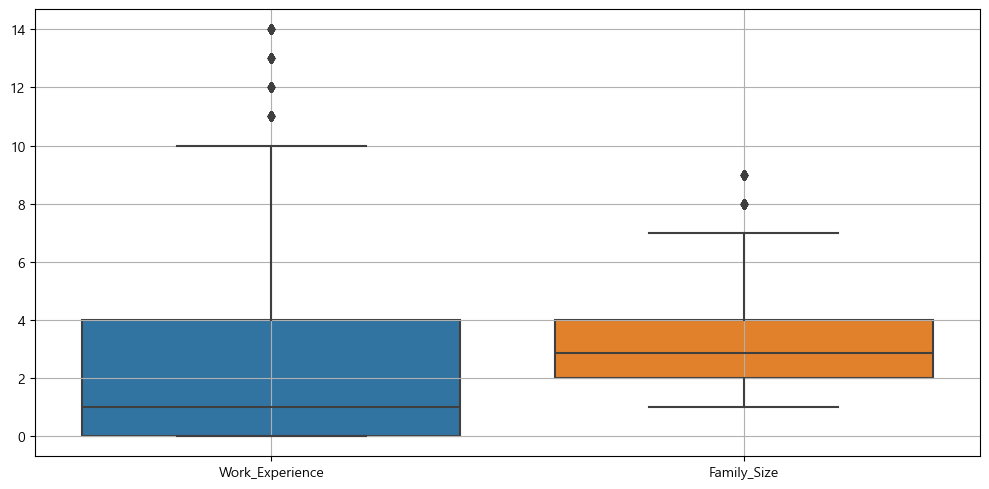

In [39]:
my_boxplot(df4, dpi=100)

> 이상치가 조금 보이나 많이 벗어나지 않고 개수도 많지 않다. 이상치는 따로 처리하지 않고 진행한다.

### (7) 종속변수 라벨링 및 카테고리 타입 라벨링

In [40]:
ldf = df4.copy()

In [42]:
ldf['Segmentation'].value_counts()

D    2836
A    2657
C    2333
B    2296
Name: Segmentation, dtype: int64

In [43]:
ldf['Segmentation'] = ldf['Segmentation'].map({'A': 0, 'B': 1,'C': 2,'D': 3})
ldf['Gender'] = ldf['Gender'].map({'Male': 0, 'Female': 1})
ldf['Ever_Married'] = ldf['Ever_Married'].map({'No': 0, 'Yes': 1})
ldf['Graduated'] = ldf['Graduated'].map({'No': 0, 'Yes': 1})
ldf['Spending_Score'] = ldf['Spending_Score'].map({'Low': 0, 'Average': 1,'High': 2})
ldf['Var_1'] = ldf['Var_1'].map({'Cat_1': 0, 'Cat_2': 1,'Cat_3': 2,'Cat_4': 3,'Cat_5': 4,'Cat_6': 5,'Cat_7': 6})
ldf['연령대'] = ldf['연령대'].map({10: 0, 20: 1,30: 2,40: 3,50: 4,60: 5,70: 6,80: 7})
ldf['Profession'] = ldf['Profession'].map({'Artist': 0, 'Healthcare': 1,'Entertainment': 2,'Doctor': 3,'Engineer': 4,'Lawyer': 5,'Executive': 6,'Marketing': 7,'Homemaker': 8})
ldf.head()

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation,연령대,Work_Experience,Family_Size
0,0,0,0,1,0,3,3,1,1.000000,4.0
1,1,1,1,4,1,3,0,2,2.624334,3.0
2,1,1,1,4,0,5,1,5,1.000000,1.0
3,0,1,1,5,2,5,1,5,0.000000,2.0
4,1,1,1,2,2,5,0,3,2.624334,6.0


In [44]:
ldf1 = ldf.astype('int')
ldf1.dtypes

Gender             int32
Ever_Married       int32
Graduated          int32
Profession         int32
Spending_Score     int32
Var_1              int32
Segmentation       int32
연령대                int32
Work_Experience    int32
Family_Size        int32
dtype: object

## #4. 탐색적 데이터 분석

### (1) 종속변수에 따른 변수의 데이터 분포 확인

In [45]:
yname = 'Segmentation'
xnames = list(df4.drop(yname, axis=1).columns)

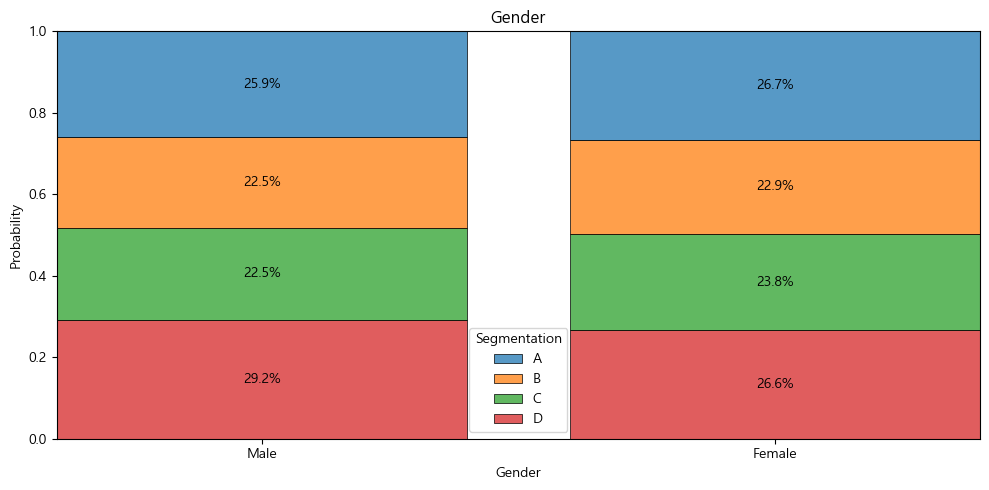

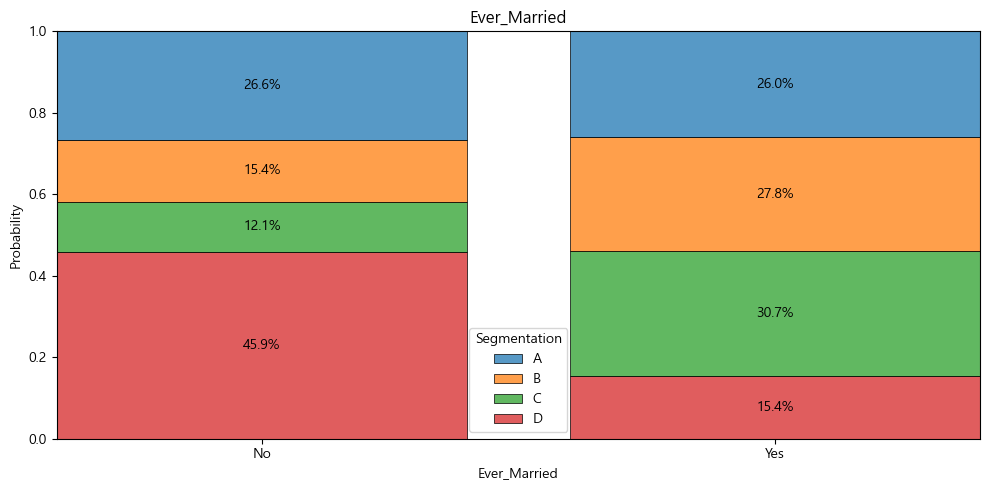

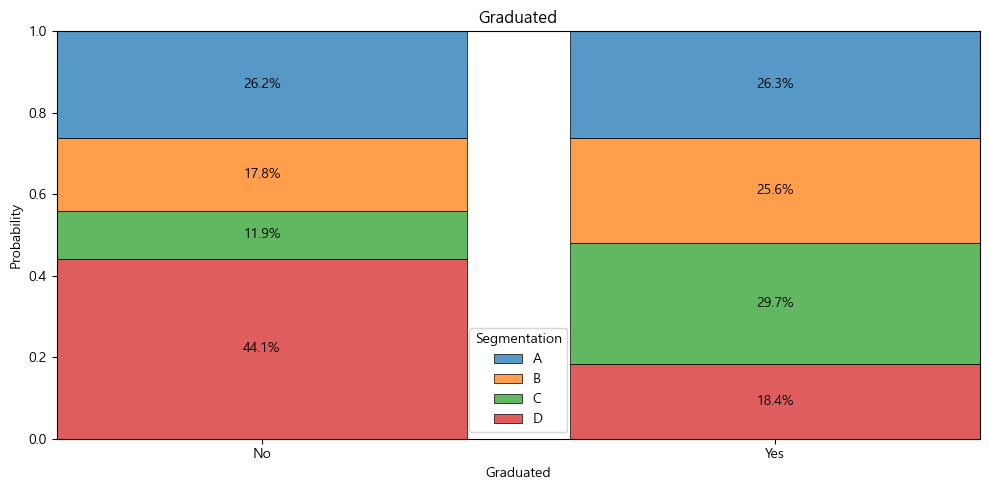

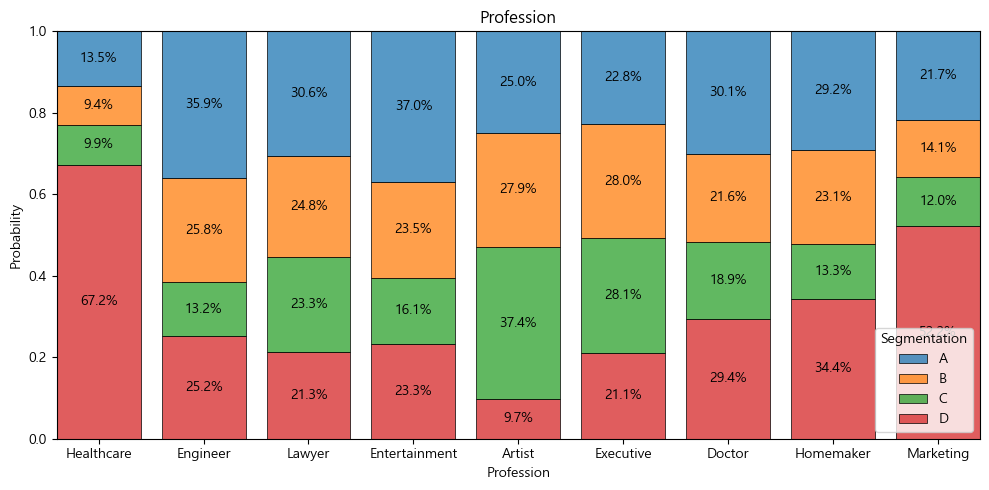

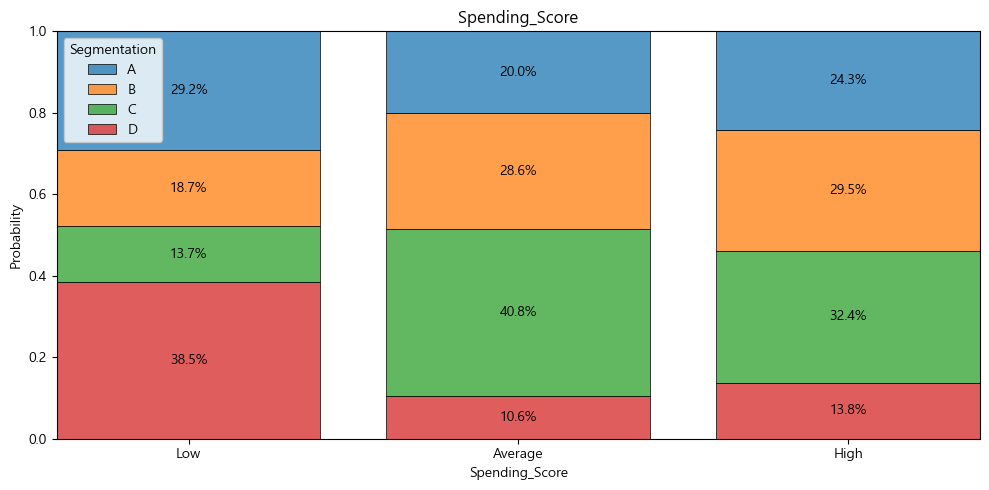

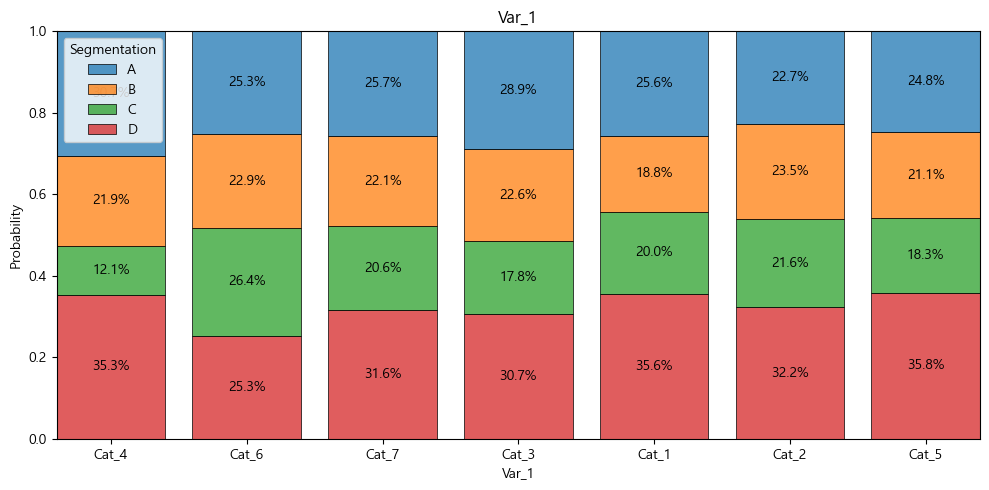

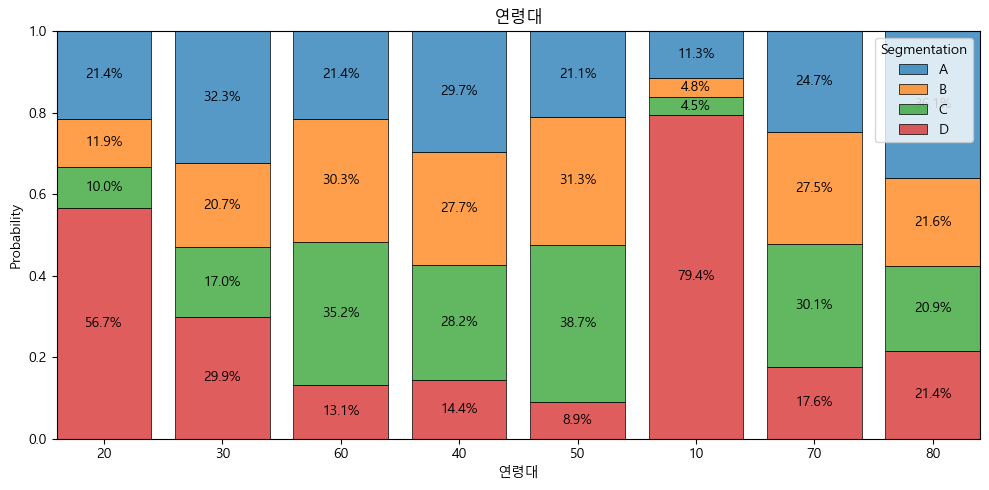

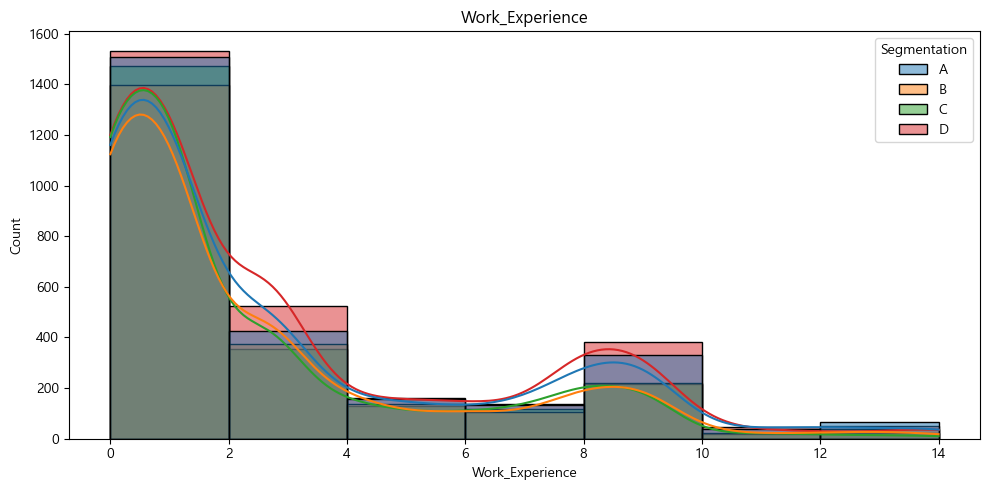

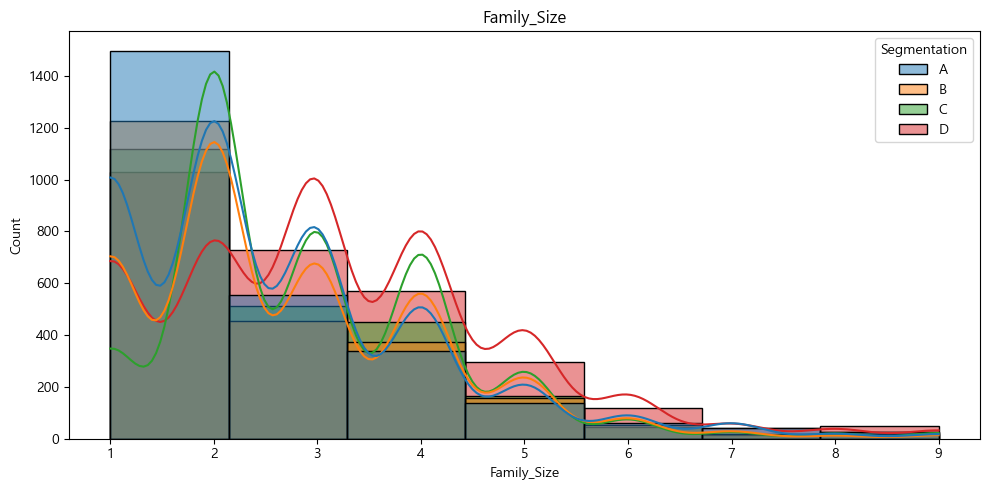

In [46]:
for x in xnames:
    if df4[x].dtype == 'category':
        my_stackplot(df4, xname=x, hue=yname, dpi=100, callback=lambda ax: ax.set_title(x))
    else:
        my_histplot(df4, xname=x, hue=yname, bins=7, dpi=100, callback=lambda ax: ax.set_title(x))

> 결혼, 졸업, 직업, 소비지출, 연령대, 경력, 가족수에 따라 고객분류별로 유의미한 차이가 보인다.

### (3) 상관분석

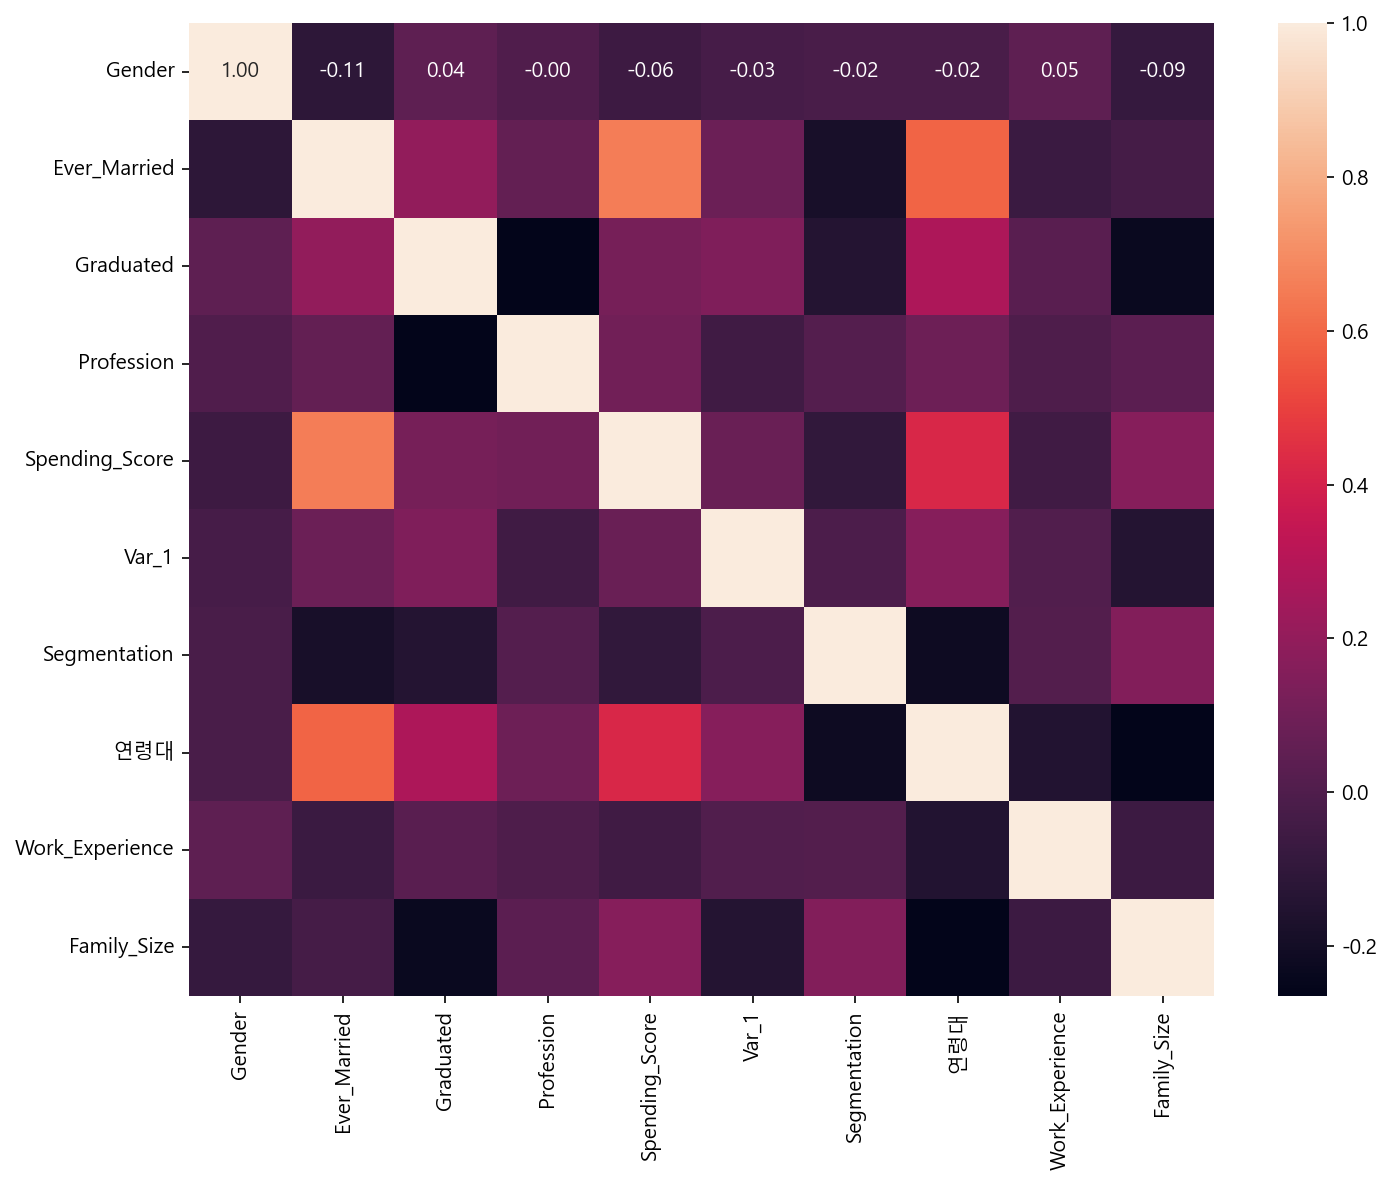

+---------------------------------------+---------------+--------------+----------+
|                                       |   correlation |      p-value | result   |
|---------------------------------------+---------------+--------------+----------|
| ('Gender', 'Ever_Married')            |     -0.114561 |  6.38899e-31 | True     |
| ('Gender', 'Graduated')               |       0.04286 |  1.60678e-05 | True     |
| ('Gender', 'Profession')              |   -0.00034083 |     0.972649 | False    |
| ('Gender', 'Spending_Score')          |    -0.0601251 |  1.41463e-09 | True     |
| ('Gender', 'Var_1')                   |    -0.0279563 |   0.00491072 | True     |
| ('Gender', 'Segmentation')            |     -0.021195 |    0.0329772 | True     |
| ('Gender', '연령대')                  |     -0.017927 |    0.0713061 | False    |
| ('Gender', 'Work_Experience')         |     0.0452318 |  5.30224e-06 | True     |
| ('Gender', 'Family_Size')             |    -0.0866543 |  2.46946e-18 | True  

In [47]:
my_correlation(ldf1,method='s',)

> - 상관분석 결과 종속변수에 상대적으로 가장 큰 영향을 끼치는 변수는 연령대(음), 결혼상태(음), 가족수(양)으로 나타났다. 모두 약한 상관관계지만 통계적으로는 유의미하다.  
> - 결혼상태와 소비지출, 연령대와 소비지출이 상대적으로 강한 상관관계를 나타냈다.

## #5. 데이터 전처리

In [48]:
ldf.dtypes

Gender             category
Ever_Married       category
Graduated          category
Profession         category
Spending_Score     category
Var_1              category
Segmentation       category
연령대                category
Work_Experience     float64
Family_Size         float64
dtype: object

In [49]:
# 종속변수 정수타입으로 변환
ldf['Segmentation'] = ldf['Segmentation'].astype('int')
ldf.dtypes

Gender             category
Ever_Married       category
Graduated          category
Profession         category
Spending_Score     category
Var_1              category
Segmentation          int32
연령대                category
Work_Experience     float64
Family_Size         float64
dtype: object

In [50]:
# 더미변수 생성
ldf_dummy = my_dummies(ldf)
ldf_dummy.head()

,Segmentation,Work_Experience,Family_Size,Gender_0,Ever_Married_1,Graduated_1,Profession_3,Profession_4,Profession_2,Profession_6,...,Var_1_4,Var_1_5,Var_1_6,연령대_1,연령대_2,연령대_3,연령대_4,연령대_5,연령대_6,연령대_7
0,3,1.000000,4.0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,2.624334,3.0,0,1,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,1.000000,1.0,0,1,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
3,1,0.000000,2.0,1,1,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0,2.624334,6.0,0,1,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0


## #6. 데이터 분할

In [51]:
x_train, x_test, y_train, y_test = my_train_test_split(ldf_dummy, yname='Segmentation', random_state=123)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((8097, 28), (2025, 28), (8097,), (2025,))

## #7. 로지스틱 회귀분석

[교차검증]
+----+-------+-----------+-------------------+
|    |     C | penalty   |   mean_test_score |
|----+-------+-----------+-------------------|
| 10 |     1 | l2        |          0.472151 |
|  7 |   0.1 | l2        |          0.472026 |
| 16 |   100 | l2        |          0.470051 |
| 13 |    10 | l2        |          0.469804 |
|  4 |  0.01 | l2        |          0.464616 |
|  1 | 0.001 | l2        |          0.438556 |
+----+-------+-----------+-------------------+

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.477584 |         0.48 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |      0.46441 |     0.454395 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
|

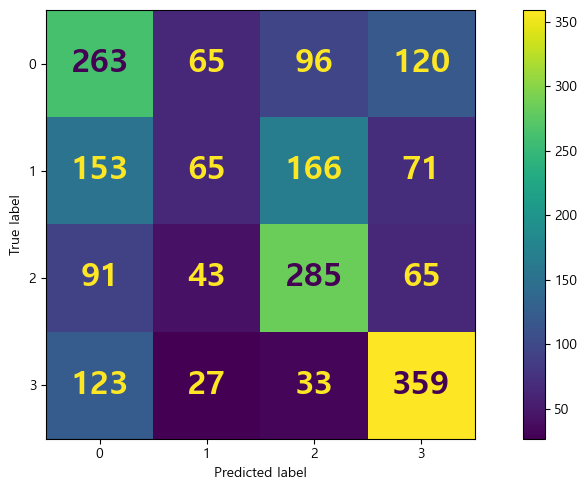


[Roc Curve]


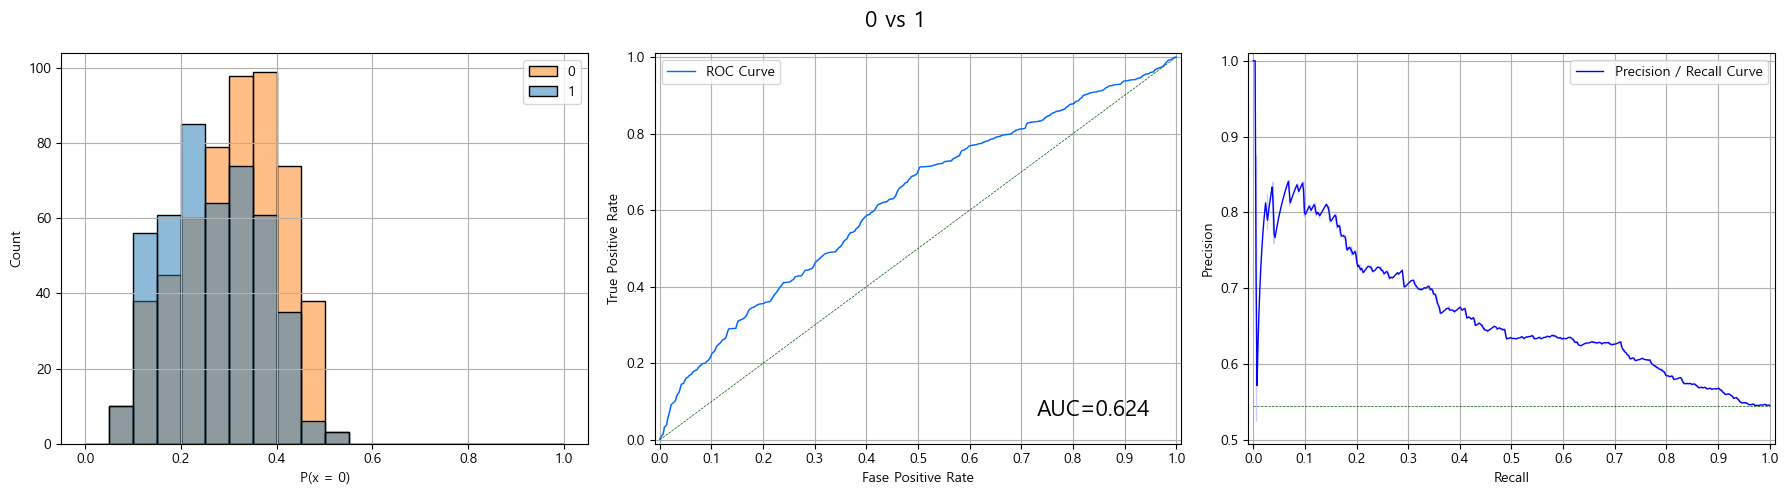

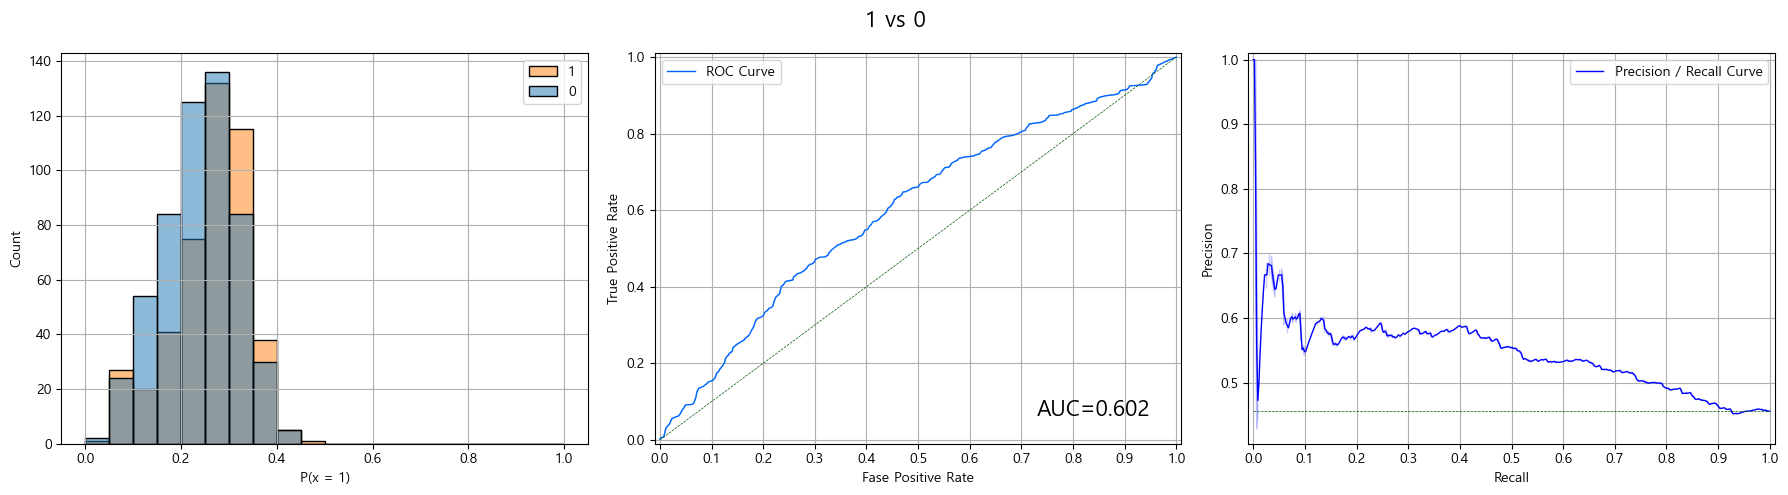

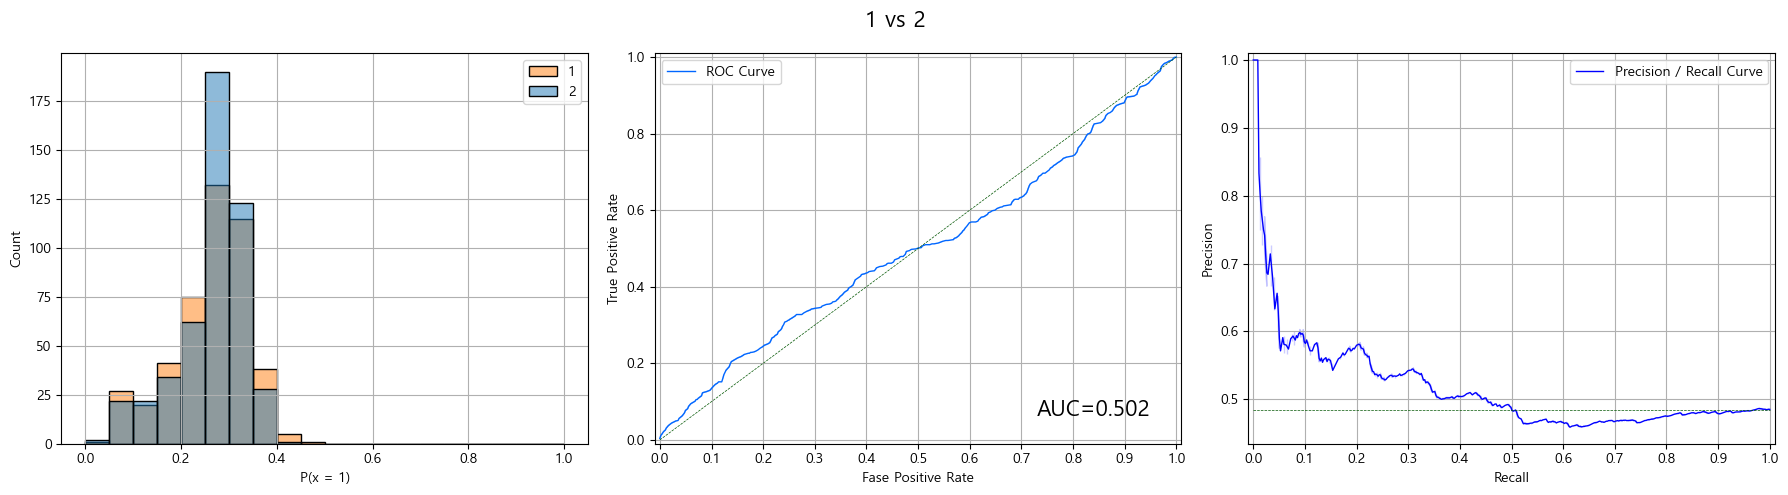

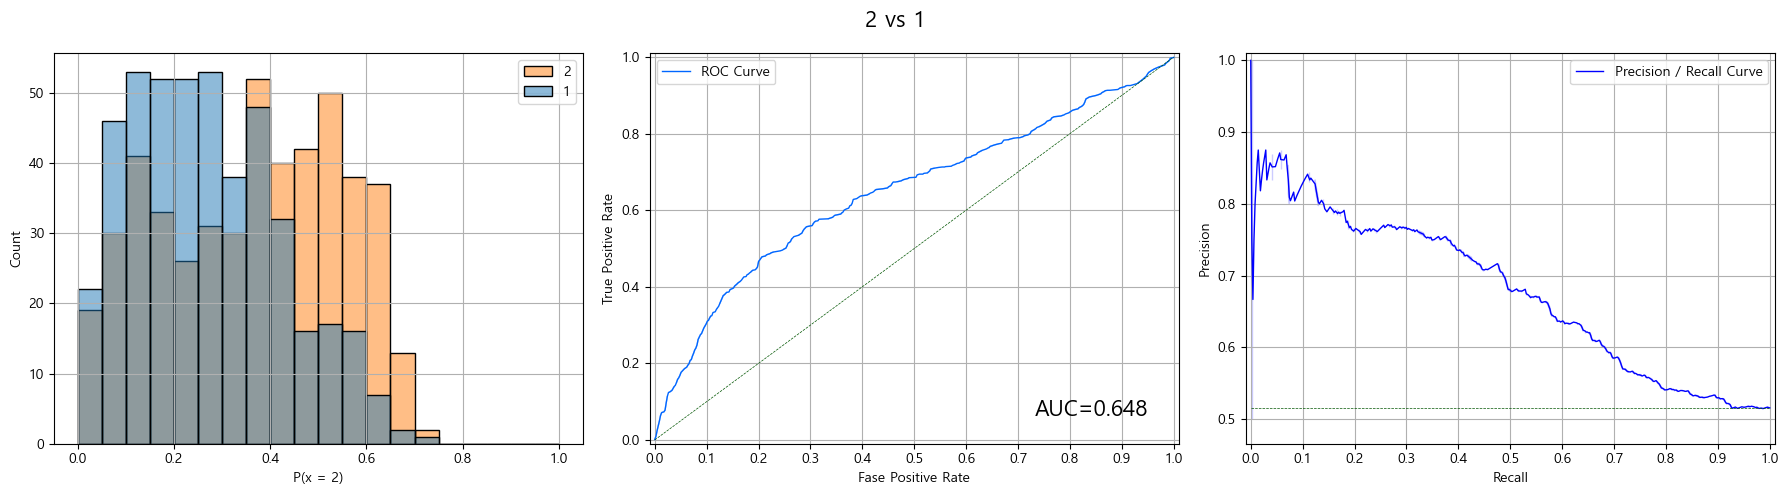

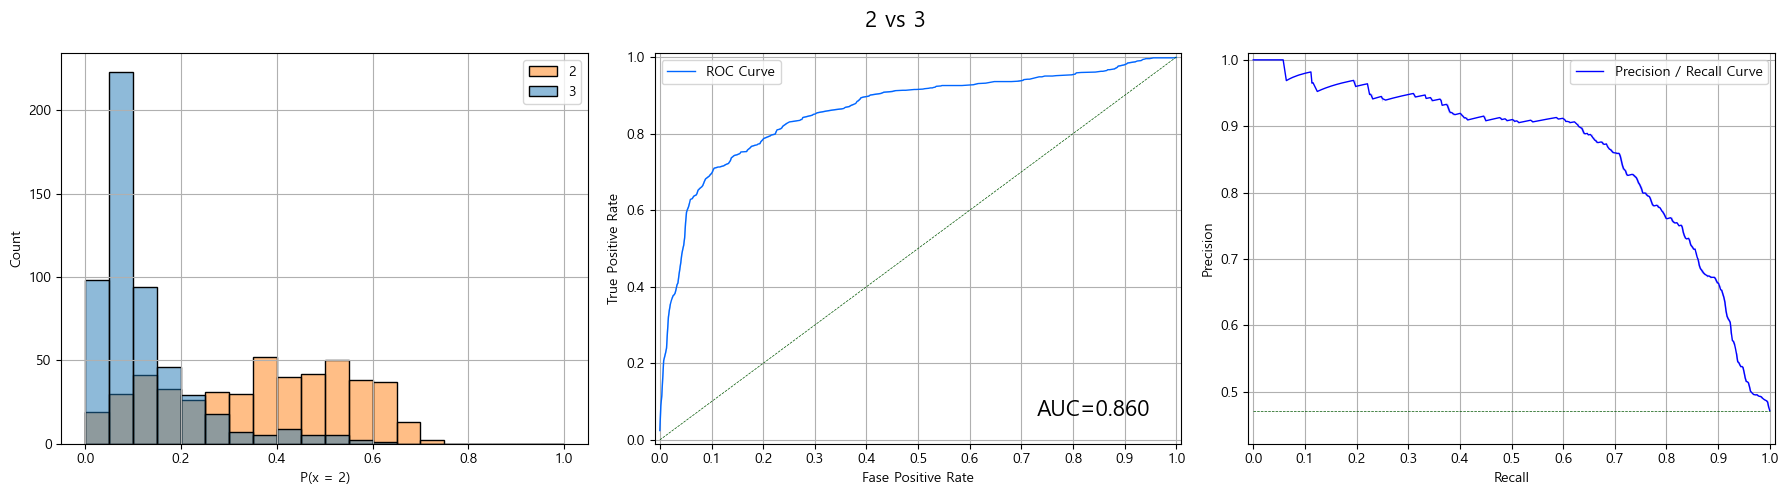

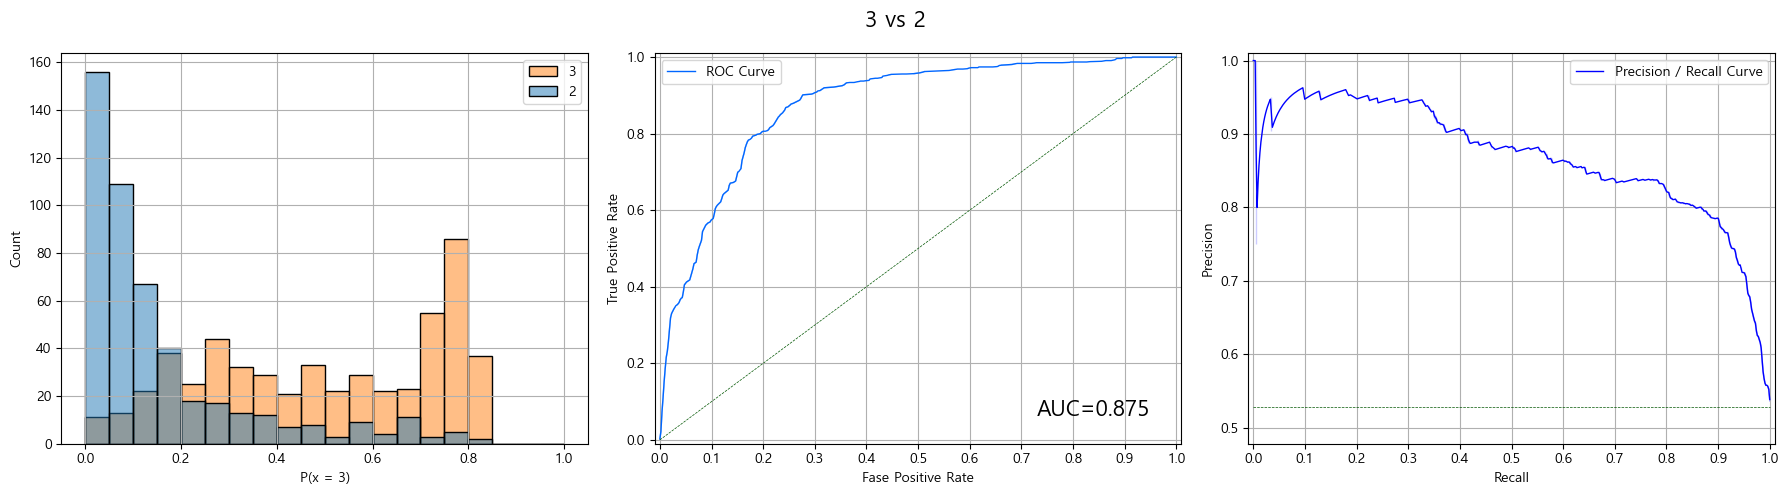

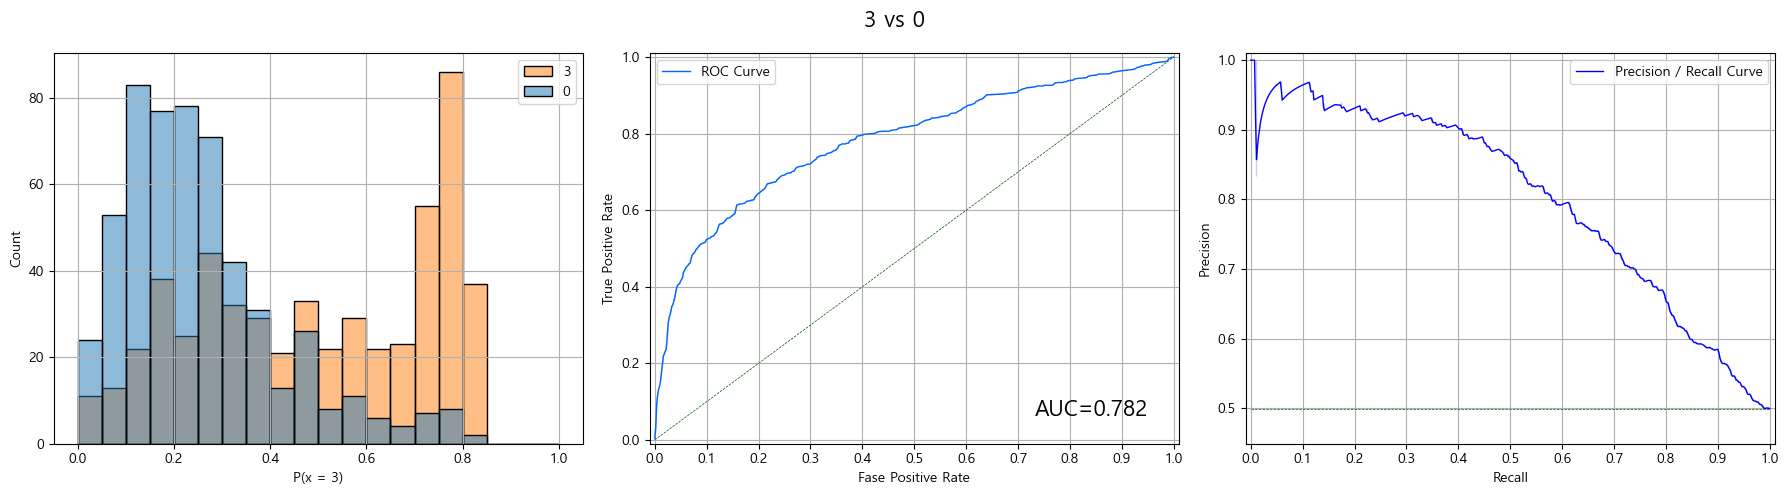

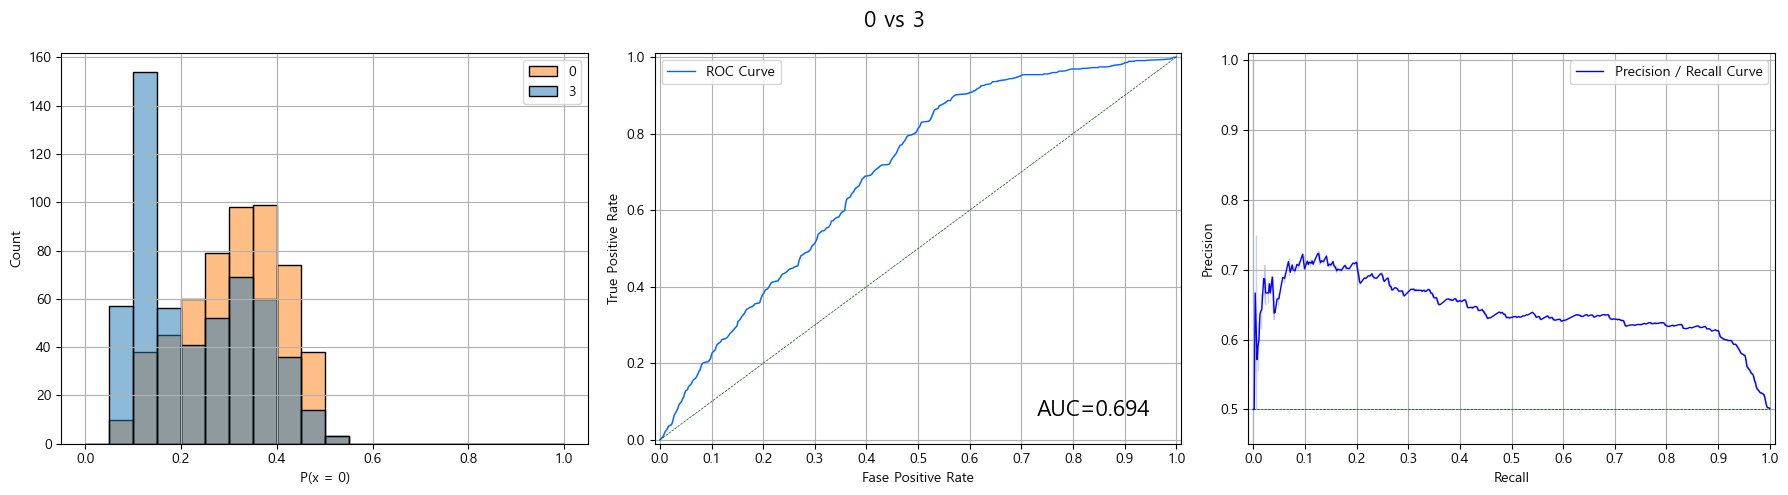

mean roc auc ovo: 0.6983

[학습곡선]


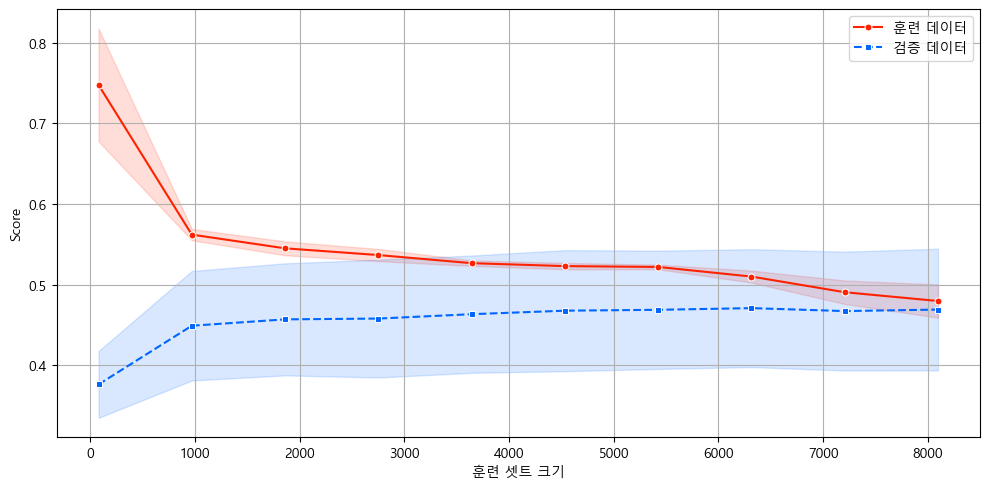

+----+--------------+---------+------------------+-----------+------------+---------+------------+---------+------------+
|    | 종속변수     |   CLASS | 독립변수         |   B(계수) |   표준오차 |       t |   유의확률 |     VIF |   OddsRate |
|----+--------------+---------+------------------+-----------+------------+---------+------------+---------+------------|
|  0 | Segmentation |       0 | Work_Experience  |    0.0108 |      0.014 |  0.7993 |      0.424 | 1.77453 |     1.0109 |
|  1 | Segmentation |       0 | Family_Size      |    -0.052 |      0.033 | -1.5581 |      0.119 | 5.46814 |     0.9494 |
|  2 | Segmentation |       0 | Gender_0         |    0.0286 |      0.096 |  0.2972 |      0.766 | 2.63725 |      1.029 |
|  3 | Segmentation |       0 | Ever_Married_1   |     0.077 |      0.127 |  0.6084 |      0.543 | 5.98779 |       1.08 |
|  4 | Segmentation |       0 | Graduated_1      |   -0.1482 |      0.102 | -1.4592 |      0.145 | 3.70747 |     0.8623 |
|  5 | Segmentation |       0 | Profession

In [ ]:
estimator = my_logistic_classification(x_train, y_train, x_test, y_test)

## #8. KNN 분류

[교차검증]
+----+-------------+---------------+-----+-----------+-------------------+
|    | algorithm   |   n_neighbors |   p | weights   |   mean_test_score |
|----+-------------+---------------+-----+-----------+-------------------|
| 32 | brute       |             7 |   1 | uniform   |          0.408423 |
| 20 | kd_tree     |             7 |   1 | uniform   |          0.407188 |
|  8 | ball_tree   |             7 |   1 | uniform   |          0.404843 |
| 10 | ball_tree   |             7 |   2 | uniform   |          0.404473 |
| 22 | kd_tree     |             7 |   2 | uniform   |           0.40447 |
| 34 | brute       |             7 |   2 | uniform   |          0.401755 |
|  4 | ball_tree   |             5 |   1 | uniform   |          0.394714 |
| 28 | brute       |             5 |   1 | uniform   |          0.394222 |
| 30 | brute       |             5 |   2 | uniform   |          0.391629 |
| 16 | kd_tree     |             5 |   1 | uniform   |          0.391132 |
|  9 | ball_tree  

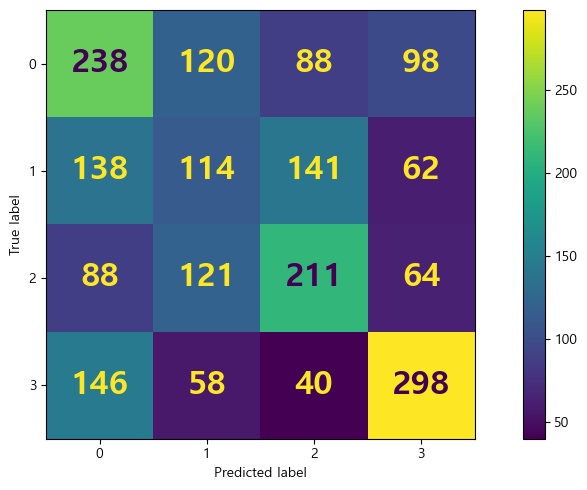


[Roc Curve]


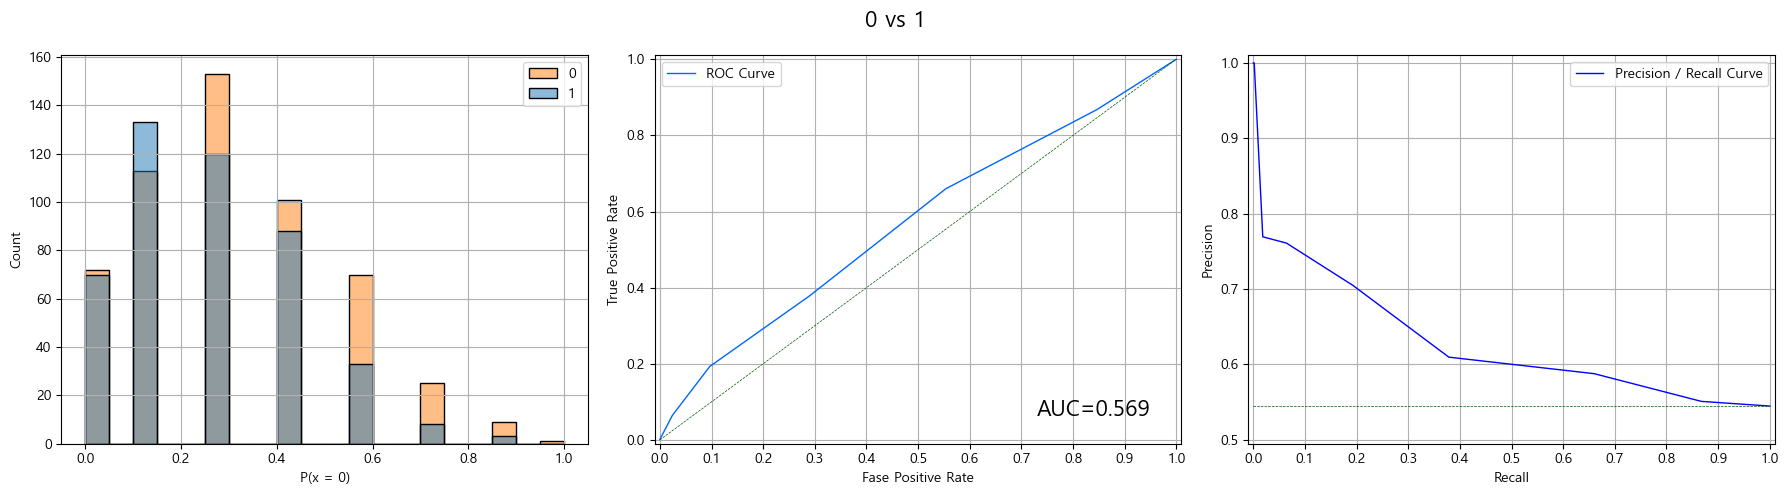

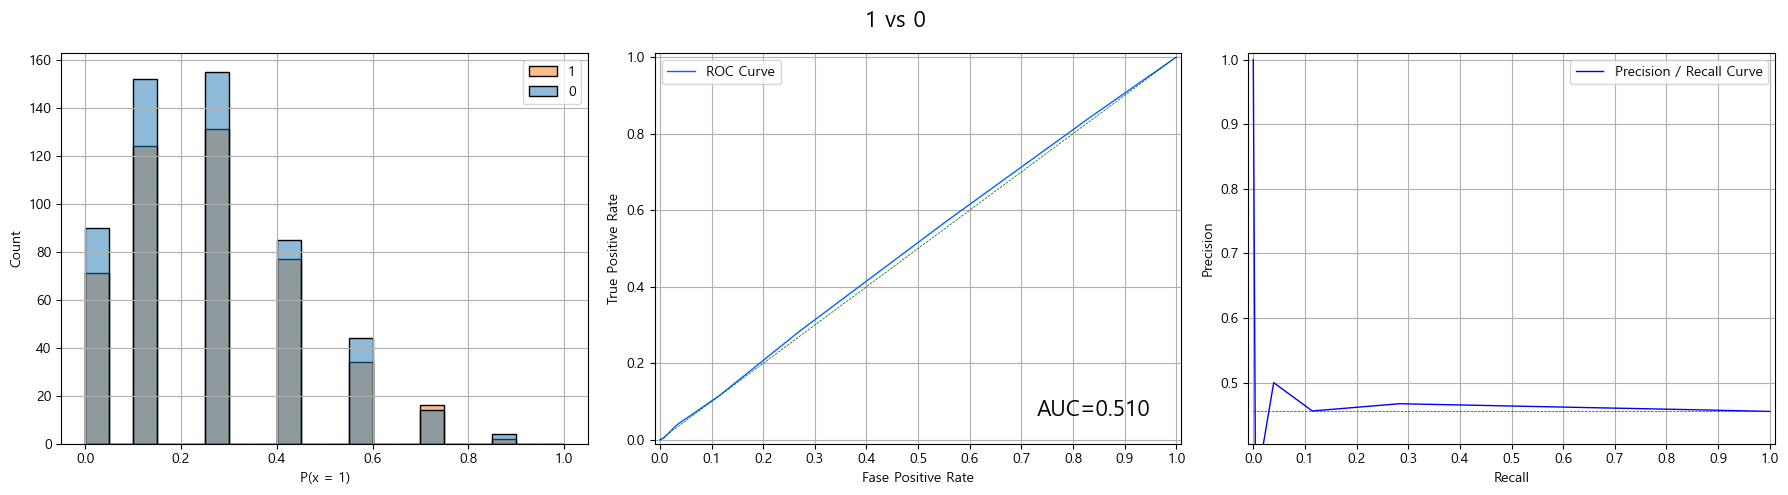

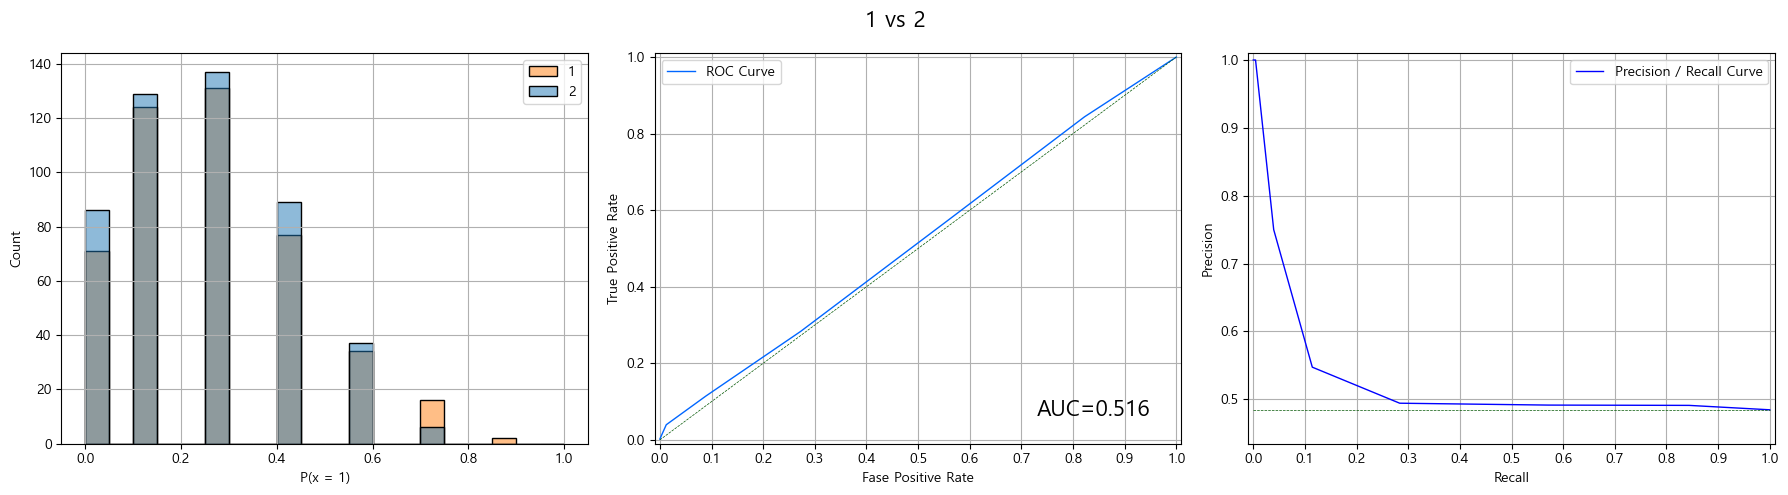

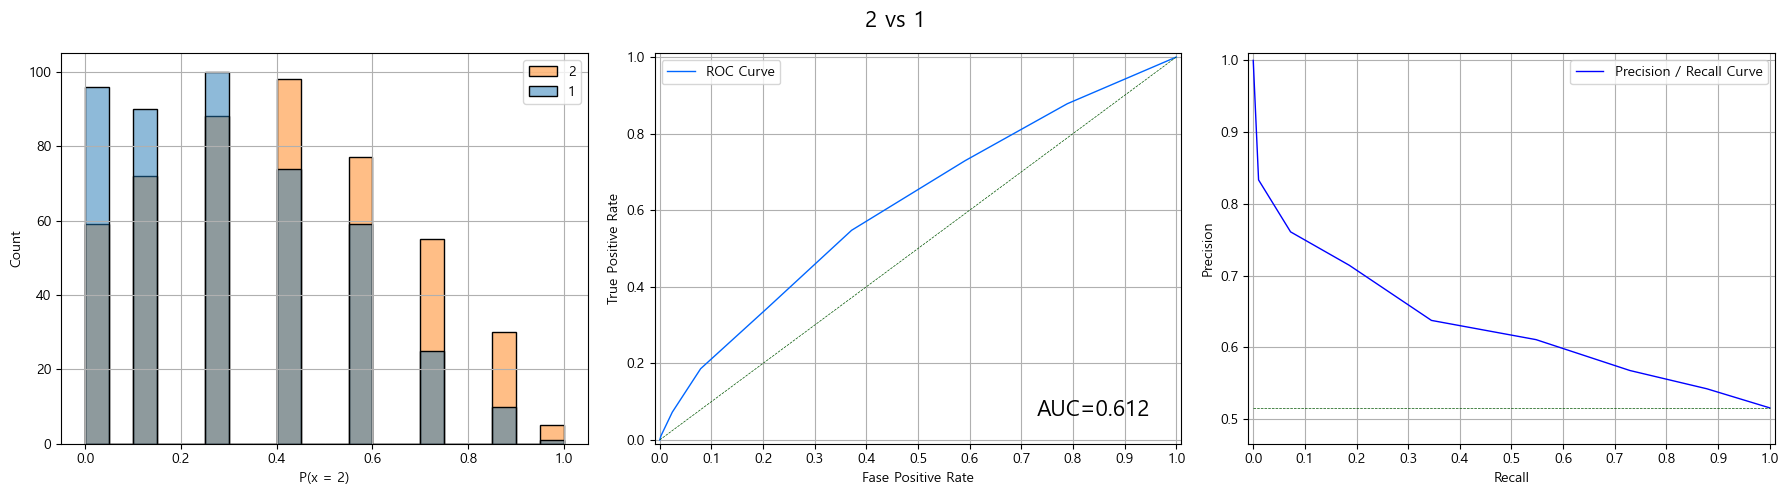

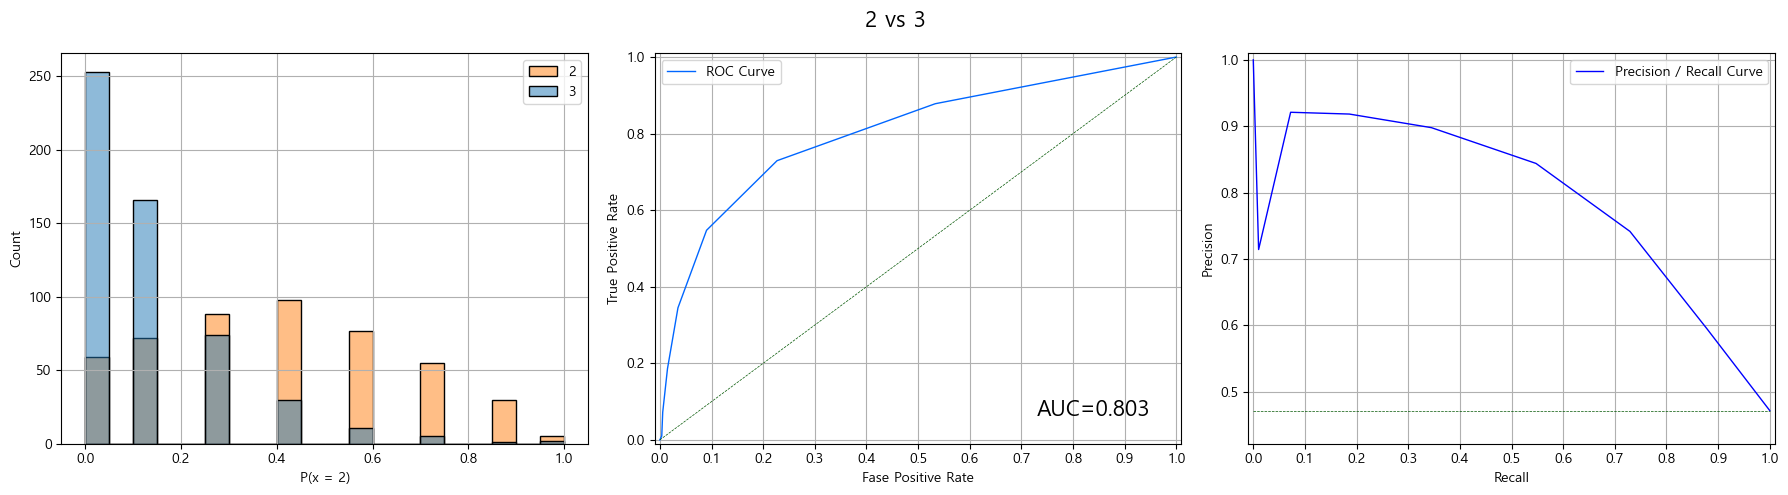

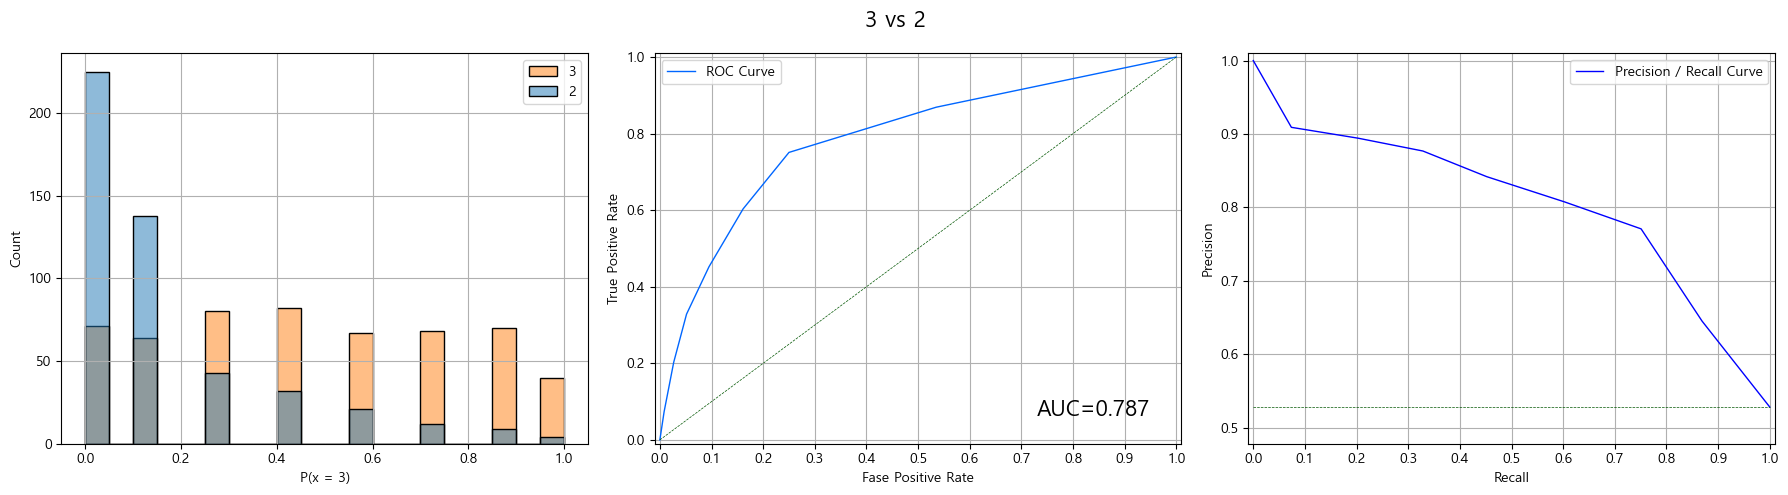

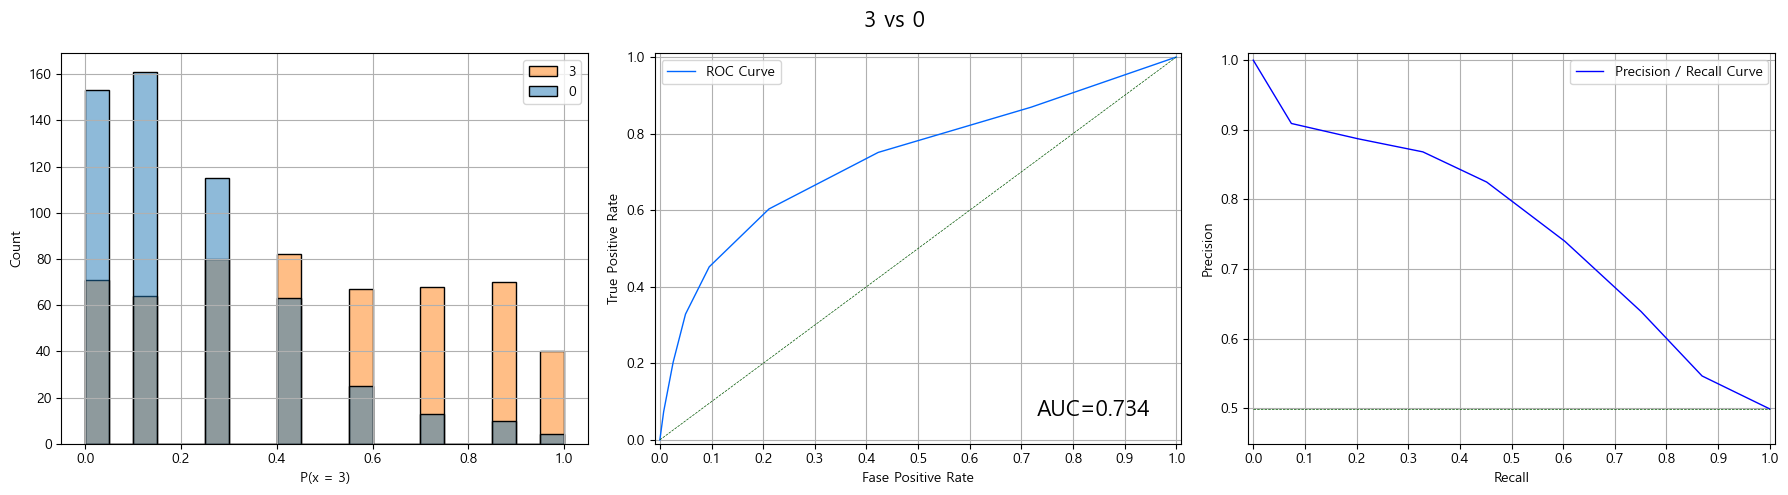

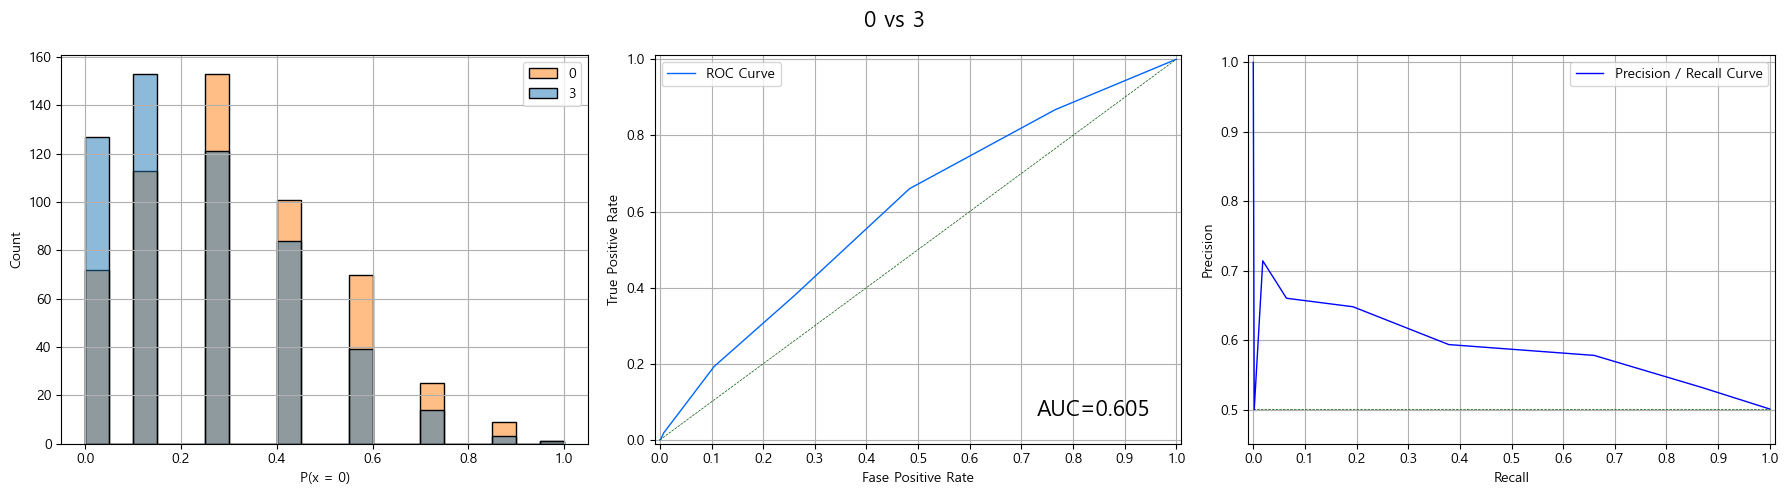

mean roc auc ovo: 0.6421

[학습곡선]


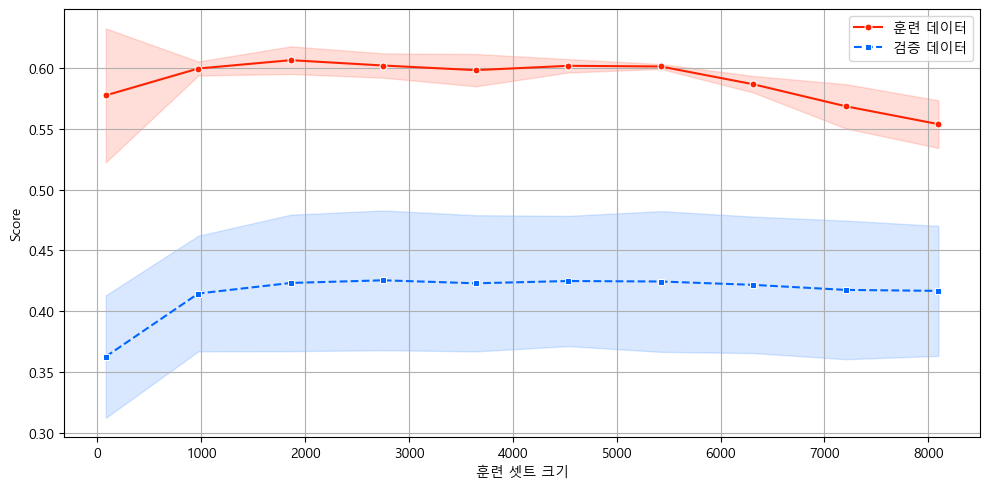

KNeighborsClassifier(algorithm='brute', n_jobs=-1, n_neighbors=7, p=1)

In [ ]:
my_knn_classification(x_train, y_train, x_test, y_test)

> 로지스틱분석과 KNN분석 결과는 다음과 같다.
>| 구분 | 로지스틱회귀 | KNN |
>|---|---|---|
>| 정확도 | 0.48 | 0.425185 |
>| 정밀도 | 0.454 | 0.419 |
>| 재현율 | 0.469 | 0.418 |
>| F1 SCORE | 0.450 | 0.418 |
>| AUC | 0.727 | 0.662 |

> 전반적으로 로지스틱회귀의 성능평가가 더 좋고 학습곡선을 보면 KNN의 경우 과소적합의 가능성이 있다.  

In [ ]:
ldf.head()

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation,연령대,Work_Experience,Family_Size
0,0,0,0,1,0,3,3,1,1.000000,4.0
1,1,1,1,4,1,3,0,2,2.624334,3.0
2,1,1,1,4,0,5,1,5,1.000000,1.0
3,0,1,1,5,2,5,1,5,0.000000,2.0
4,1,1,1,2,2,5,0,3,2.624334,6.0


## #9. 실제 데이터 적용

In [ ]:
mydf= DataFrame([
    {'Gender':0, 'Ever_Married':0,'Graduated':1, 'Profession':4, 'Spending_Score':0, 'Var_1':0,'연령대':3, 'Work_Experience':4,'Family_Size':5},

], index=['me'])
mydf.dtypes

Gender             int64
Ever_Married       int64
Graduated          int64
Profession         int64
Spending_Score     int64
Var_1              int64
연령대                int64
Work_Experience    int64
Family_Size        int64
dtype: object

In [ ]:
mydf = mydf.astype({'Gender':'category','Ever_Married':'category','Graduated':'category',
                    'Profession':'category','Spending_Score':'category', 'Var_1':'category','연령대':'category'})
mydf.dtypes

Gender             category
Ever_Married       category
Graduated          category
Profession         category
Spending_Score     category
Var_1              category
연령대                category
Work_Experience       int64
Family_Size           int64
dtype: object

In [ ]:
mydf

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,연령대,Work_Experience,Family_Size
me,0,0,1,4,0,0,3,4,5


In [ ]:
ldf_dummy.columns

Index(['Segmentation', 'Work_Experience', 'Family_Size', 'Gender_0',
       'Ever_Married_1', 'Graduated_1', 'Profession_3', 'Profession_4',
       'Profession_2', 'Profession_6', 'Profession_1', 'Profession_8',
       'Profession_5', 'Profession_7', 'Spending_Score_2', 'Spending_Score_0',
       'Var_1_1', 'Var_1_2', 'Var_1_3', 'Var_1_4', 'Var_1_5', 'Var_1_6',
       '연령대_1', '연령대_2', '연령대_3', '연령대_4', '연령대_5', '연령대_6', '연령대_7'],
      dtype='object')

In [ ]:
mydf= DataFrame([
    {'Work_Experience':4, 'Family_Size':5,'Gender_0':1, 'Ever_Married_1':0, 'Graduated_1':1, 'Profession_3':1,'Profession_4':0, 'Profession_2':0,'Profession_6':0,'Profession_1':0,'Profession_8':0,'Profession_5':0,
     'Profession_7':0,'Spending_Score_2':0,'Spending_Score_0':1,
     'Var_1_1':1,'Var_1_2':0,'Var_1_3':0,'Var_1_4':0, 'Var_1_5':0, 'Var_1_6':0,
     '연령대_1':0, '연령대_2':0, '연령대_3':1, '연령대_4':0, '연령대_5':0, '연령대_6':0, '연령대_7':0}

], index=['me'])
mydf

,Work_Experience,Family_Size,Gender_0,Ever_Married_1,Graduated_1,Profession_3,Profession_4,Profession_2,Profession_6,Profession_1,...,Var_1_4,Var_1_5,Var_1_6,연령대_1,연령대_2,연령대_3,연령대_4,연령대_5,연령대_6,연령대_7
me,4,5,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
pred = estimator.predict_proba(mydf)
pred

array([[0.30078654, 0.26260558, 0.22360283, 0.21300504]])

In [ ]:
print(f'{mydf.index[0]}님의 고객 클래스는 {round(pred[0][0],2)*100}%의 확률로 "A"입니다.')

me님의 고객 클래스는 30.0%의 확률로 "A"입니다.


# #10. 파생변수 생성

In [52]:
df4.head()

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation,연령대,Work_Experience,Family_Size
0,Male,No,No,Healthcare,Low,Cat_4,D,20,1.000000,4.0
1,Female,Yes,Yes,Engineer,Average,Cat_4,A,30,2.624334,3.0
2,Female,Yes,Yes,Engineer,Low,Cat_6,B,60,1.000000,1.0
3,Male,Yes,Yes,Lawyer,High,Cat_6,B,60,0.000000,2.0
4,Female,Yes,Yes,Entertainment,High,Cat_6,A,40,2.624334,6.0


> -  D등급으로 분류된 고객의 특성이 뚜렷한 부분이 보여서 이를 이용한 파생변수를 생성한다.
> - 결혼 No, 졸업 No, Profession- Healthcare, Marketing, Spending_Score Low, 연령대- 10,20 

In [89]:
df_add = df4.copy()
df_add.copy() 

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation,연령대,Work_Experience,Family_Size,D
0,Male,No,No,Healthcare,Low,Cat_4,D,20,1.000000,4.0,1
1,Female,Yes,Yes,Engineer,Average,Cat_4,A,30,2.624334,3.0,NaN
2,Female,Yes,Yes,Engineer,Low,Cat_6,B,60,1.000000,1.0,NaN
3,Male,Yes,Yes,Lawyer,High,Cat_6,B,60,0.000000,2.0,NaN
4,Female,Yes,Yes,Entertainment,High,Cat_6,A,40,2.624334,6.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10117,Male,No,No,Healthcare,Low,Cat_6,B,20,9.000000,4.0,1
10118,Female,No,Yes,Doctor,Low,Cat_6,A,30,1.000000,1.0,1
10119,Female,No,Yes,Entertainment,Low,Cat_6,C,50,2.624334,2.0,1
10120,Male,Yes,Yes,Executive,High,Cat_4,C,40,1.000000,5.0,NaN


In [90]:
def getD(x):
    if x == 'No':
        classes = 1
    elif x == 'Healthcare':
        classes = 1
    elif x == 'Marketing':
        classes = 1        
    elif x == 'Low':
        classes = 1
    elif x == 10:
        classes = 1
    elif x == 20:
        classes = 1
        
    else:
        classes = '0'
        
    return classes

In [91]:
df_add['D'] = df_add['Ever_Married'].apply(getD)
df_add['D'] = df_add['Graduated'].apply(getD)
df_add['D'] = df_add['Profession'].apply(getD)
df_add['D'] = df_add['Spending_Score'].apply(getD)
df_add['D'] = df_add['연령대'].apply(getD)
df_add.head()

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation,연령대,Work_Experience,Family_Size,D
0,Male,No,No,Healthcare,Low,Cat_4,D,20,1.000000,4.0,1
1,Female,Yes,Yes,Engineer,Average,Cat_4,A,30,2.624334,3.0,0
2,Female,Yes,Yes,Engineer,Low,Cat_6,B,60,1.000000,1.0,0
3,Male,Yes,Yes,Lawyer,High,Cat_6,B,60,0.000000,2.0,0
4,Female,Yes,Yes,Entertainment,High,Cat_6,A,40,2.624334,6.0,0


In [92]:
df_add['D'].value_counts()

0    7849
1    2273
Name: D, dtype: int64

In [93]:
df_add.dtypes

Gender             category
Ever_Married       category
Graduated          category
Profession         category
Spending_Score     category
Var_1              category
Segmentation       category
연령대                category
Work_Experience     float64
Family_Size         float64
D                    object
dtype: object

In [94]:
df_add['Segmentation'] = df_add['Segmentation'].map({'A': 0, 'B': 1,'C': 2,'D': 3})
df_add['Gender'] = df_add['Gender'].map({'Male': 0, 'Female': 1})
df_add['Ever_Married'] = df_add['Ever_Married'].map({'No': 0, 'Yes': 1})
df_add['Graduated'] = df_add['Graduated'].map({'No': 0, 'Yes': 1})
df_add['Spending_Score'] = df_add['Spending_Score'].map({'Low': 0, 'Average': 1,'High': 2})
df_add['Var_1'] = df_add['Var_1'].map({'Cat_1': 0, 'Cat_2': 1,'Cat_3': 2,'Cat_4': 3,'Cat_5': 4,'Cat_6': 5,'Cat_7': 6})
df_add['연령대'] = df_add['연령대'].map({10: 0, 20: 1,30: 2,40: 3,50: 4,60: 5,70: 6,80: 7})
df_add['Profession'] = df_add['Profession'].map({'Artist': 0, 'Healthcare': 1,'Entertainment': 2,'Doctor': 3,'Engineer': 4,'Lawyer': 5,'Executive': 6,'Marketing': 7,'Homemaker': 8})
df_add.head()

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation,연령대,Work_Experience,Family_Size,D
0,0,0,0,1,0,3,3,1,1.000000,4.0,1
1,1,1,1,4,1,3,0,2,2.624334,3.0,0
2,1,1,1,4,0,5,1,5,1.000000,1.0,0
3,0,1,1,5,2,5,1,5,0.000000,2.0,0
4,1,1,1,2,2,5,0,3,2.624334,6.0,0


In [99]:
df_add['Segmentation'] = df_add['Segmentation'].astype('int')
df_add['D'] = df_add['D'].astype('category')
df_add.dtypes


Gender             category
Ever_Married       category
Graduated          category
Profession         category
Spending_Score     category
Var_1              category
Segmentation          int32
연령대                category
Work_Experience     float64
Family_Size         float64
D                  category
dtype: object

In [100]:
# 더미변수 생성
adddf_dummy = my_dummies(df_add)
adddf_dummy.head()

,Segmentation,Work_Experience,Family_Size,Gender_0,Ever_Married_1,Graduated_1,Profession_3,Profession_4,Profession_2,Profession_6,...,Var_1_5,Var_1_6,연령대_1,연령대_2,연령대_3,연령대_4,연령대_5,연령대_6,연령대_7,D_0
0,3,1.000000,4.0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,2.624334,3.0,0,1,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,1,1.000000,1.0,0,1,1,0,1,0,0,...,1,0,0,0,0,0,1,0,0,1
3,1,0.000000,2.0,1,1,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
4,0,2.624334,6.0,0,1,1,0,0,1,0,...,1,0,0,0,1,0,0,0,0,1


In [101]:
x_train, x_test, y_train, y_test = my_train_test_split(adddf_dummy, yname='Segmentation', random_state=123)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((8097, 29), (2025, 29), (8097,), (2025,))

[교차검증]
+----+-------+-----------+-------------------+
|    |     C | penalty   |   mean_test_score |
|----+-------+-----------+-------------------|
| 10 |     1 | l2        |           0.47141 |
|  7 |   0.1 | l2        |          0.470915 |
| 13 |    10 | l2        |          0.469928 |
| 16 |   100 | l2        |          0.469804 |
|  4 |  0.01 | l2        |          0.463505 |
|  1 | 0.001 | l2        |           0.43942 |
+----+-------+-----------+-------------------+

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.477214 |     0.480494 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.463582 |     0.454953 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
|

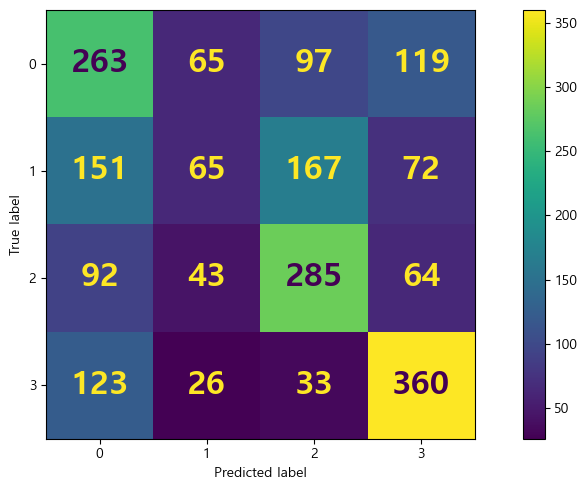


[Roc Curve]


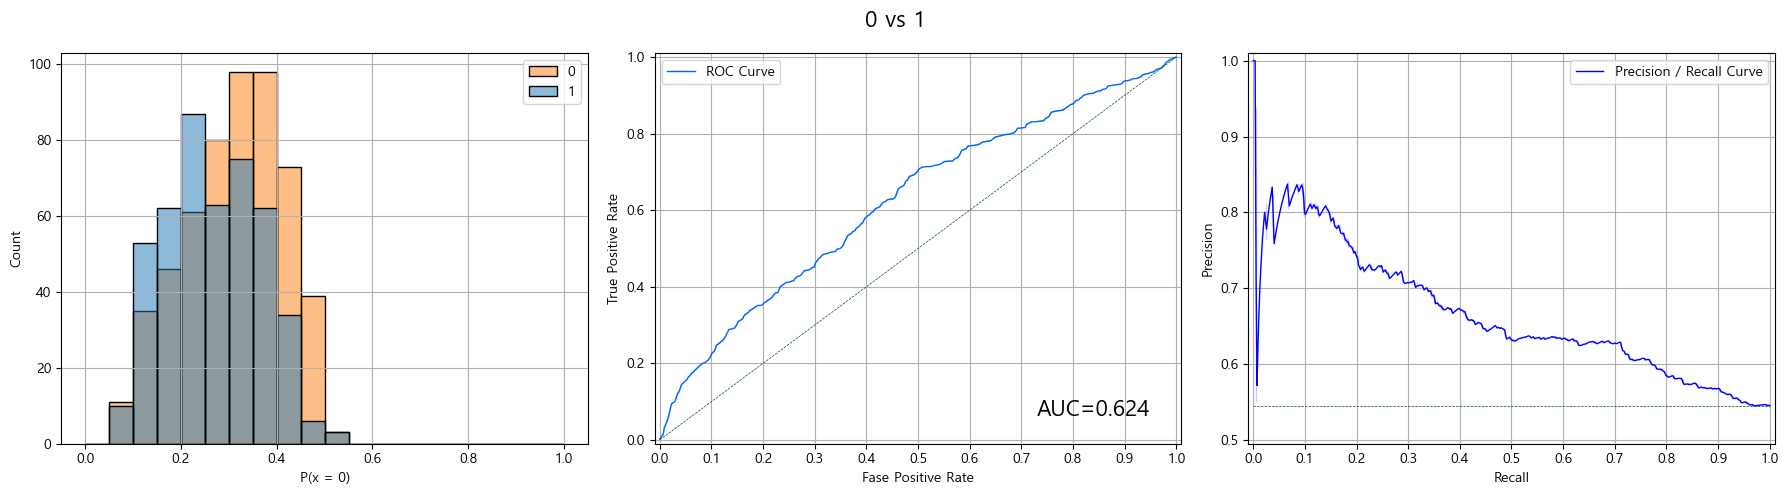

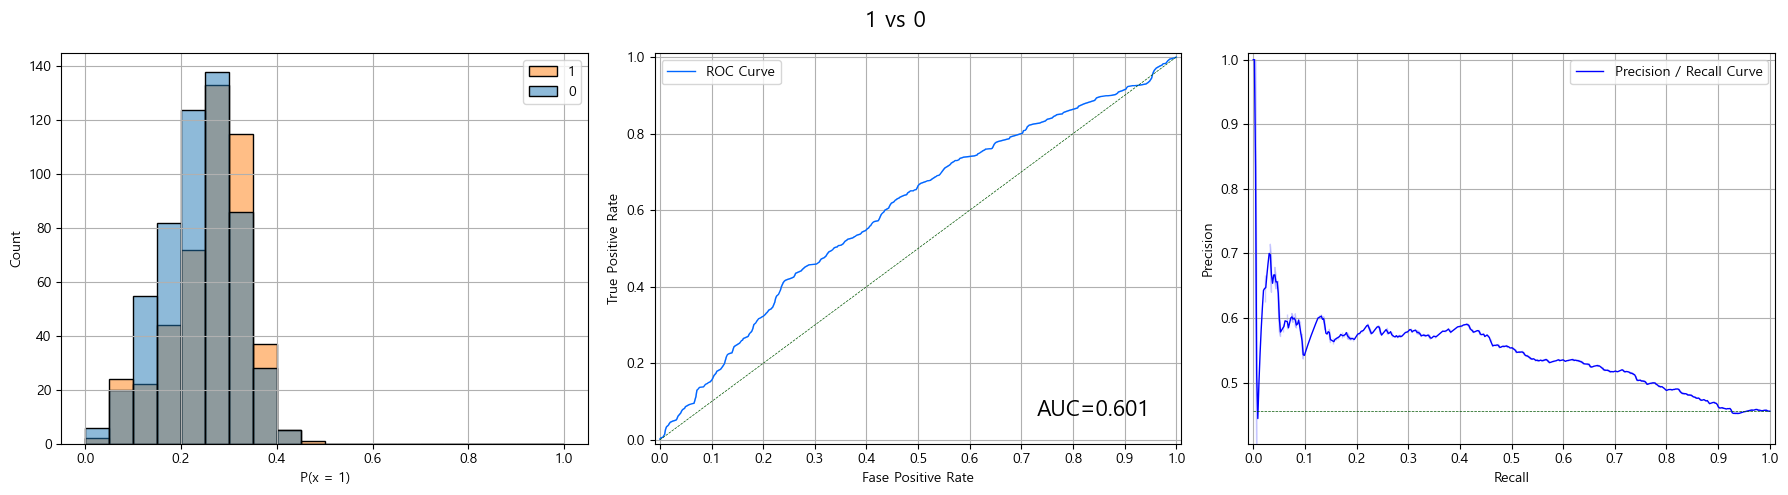

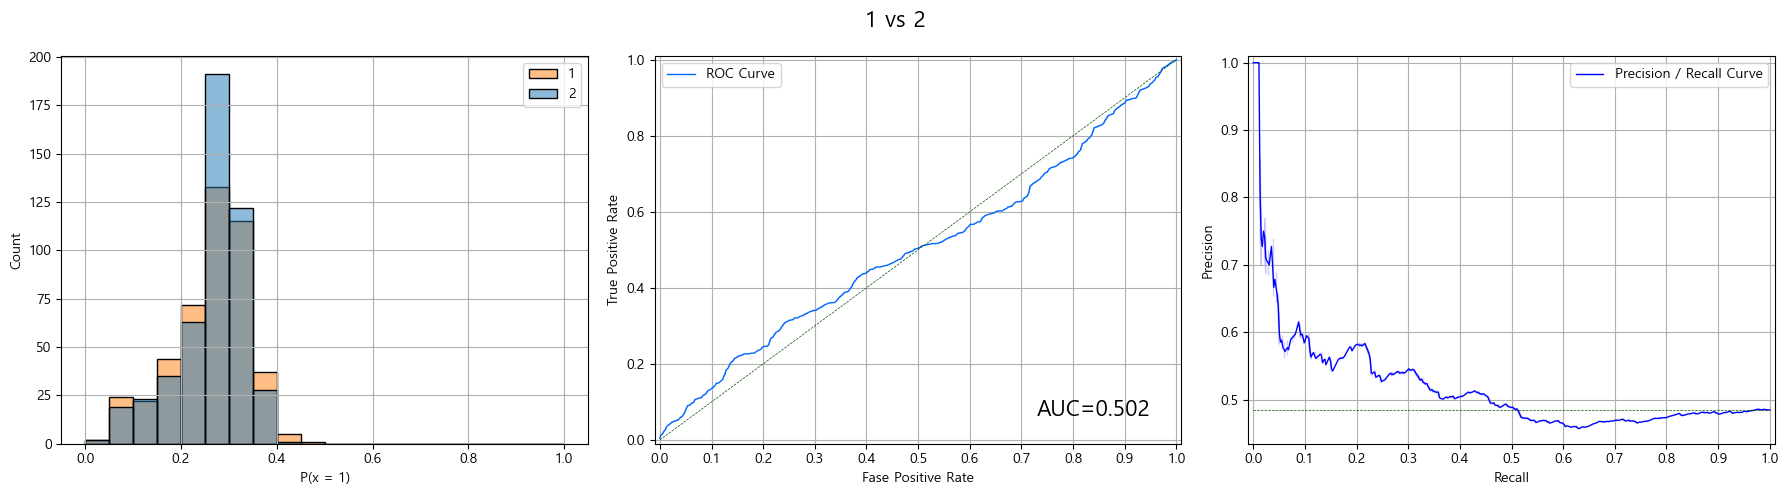

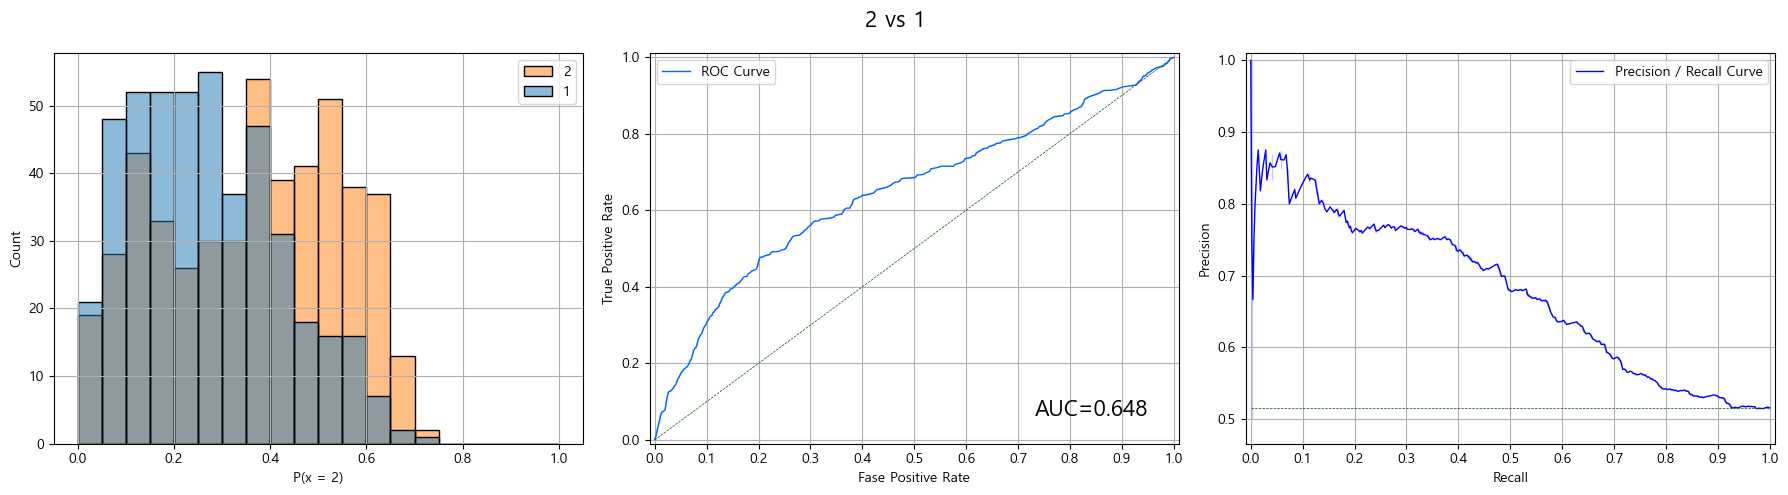

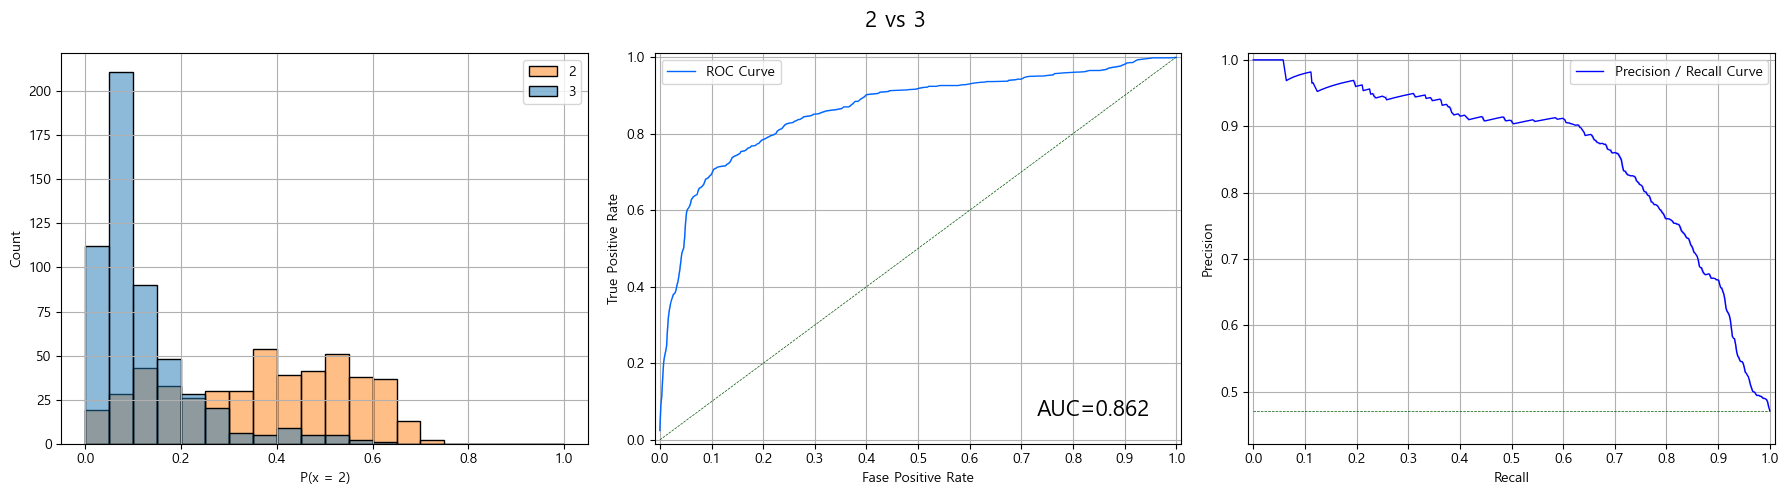

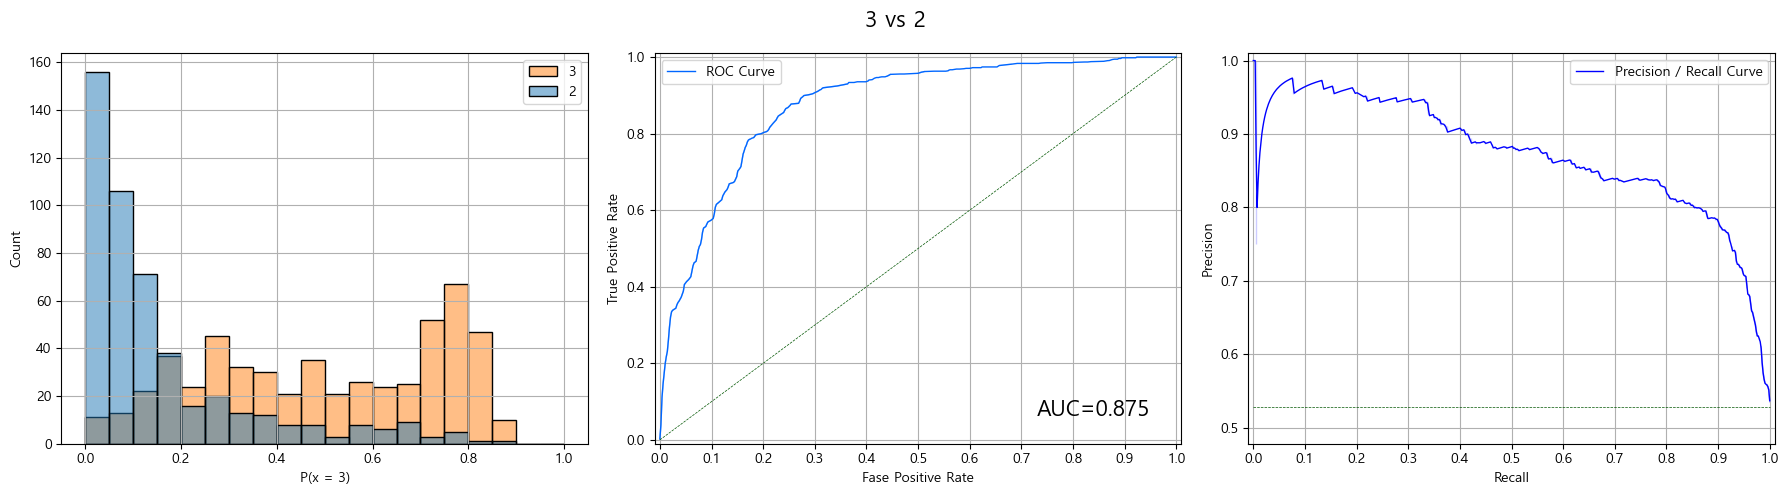

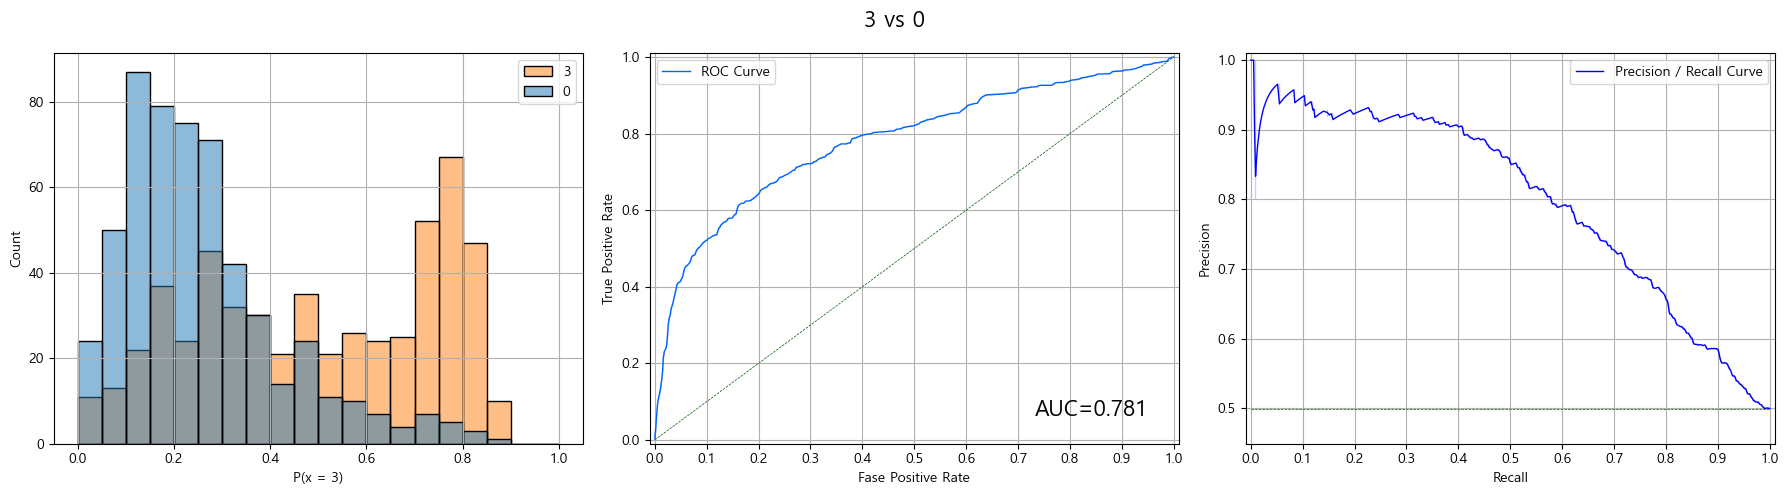

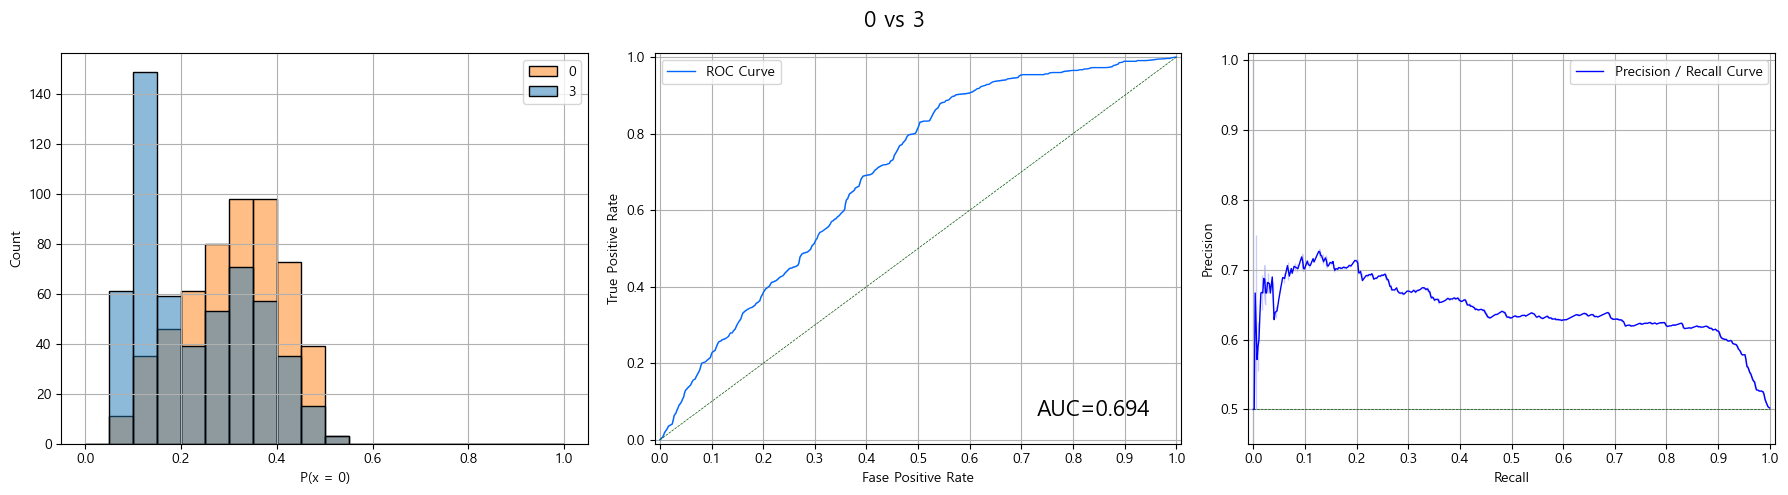

mean roc auc ovo: 0.6985

[학습곡선]


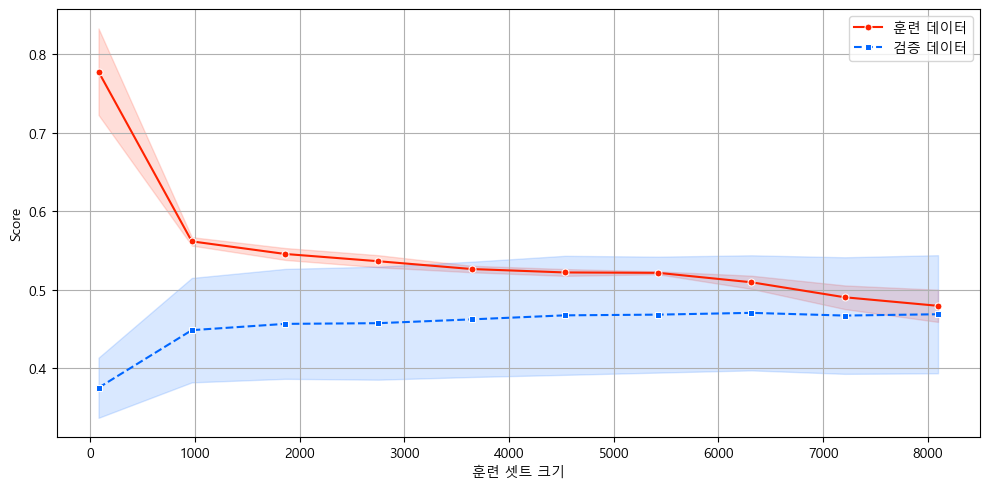

+----+--------------+---------+------------------+-----------+------------+---------+------------+---------+------------+
|    | 종속변수     |   CLASS | 독립변수         |   B(계수) |   표준오차 |       t |   유의확률 |     VIF |   OddsRate |
|----+--------------+---------+------------------+-----------+------------+---------+------------+---------+------------|
|  0 | Segmentation |       0 | Work_Experience  |    0.0108 |      0.014 |  0.7948 |      0.427 | 1.77453 |     1.0108 |
|  1 | Segmentation |       0 | Family_Size      |   -0.0525 |      0.033 | -1.5726 |      0.116 | 5.46814 |     0.9489 |
|  2 | Segmentation |       0 | Gender_0         |    0.0287 |      0.096 |  0.2978 |      0.766 | 2.63725 |     1.0291 |
|  3 | Segmentation |       0 | Ever_Married_1   |    0.0782 |      0.127 |  0.6176 |      0.537 | 5.98779 |     1.0813 |
|  4 | Segmentation |       0 | Graduated_1      |   -0.1473 |      0.102 | -1.4509 |      0.147 | 3.70747 |      0.863 |
|  5 | Segmentation |       0 | Profession

In [102]:
estimator = my_logistic_classification(x_train, y_train, x_test, y_test)

[교차검증]
+----+-------------+---------------+-----+-----------+-------------------+
|    | algorithm   |   n_neighbors |   p | weights   |   mean_test_score |
|----+-------------+---------------+-----+-----------+-------------------|
| 20 | kd_tree     |             7 |   1 | uniform   |          0.409658 |
| 22 | kd_tree     |             7 |   2 | uniform   |           0.40867 |
| 32 | brute       |             7 |   1 | uniform   |          0.407435 |
| 10 | ball_tree   |             7 |   2 | uniform   |          0.406944 |
|  8 | ball_tree   |             7 |   1 | uniform   |          0.406696 |
| 34 | brute       |             7 |   2 | uniform   |          0.404225 |
|  4 | ball_tree   |             5 |   1 | uniform   |          0.395579 |
|  6 | ball_tree   |             5 |   2 | uniform   |          0.395457 |
| 28 | brute       |             5 |   1 | uniform   |          0.393974 |
| 30 | brute       |             5 |   2 | uniform   |          0.392864 |
| 16 | kd_tree    

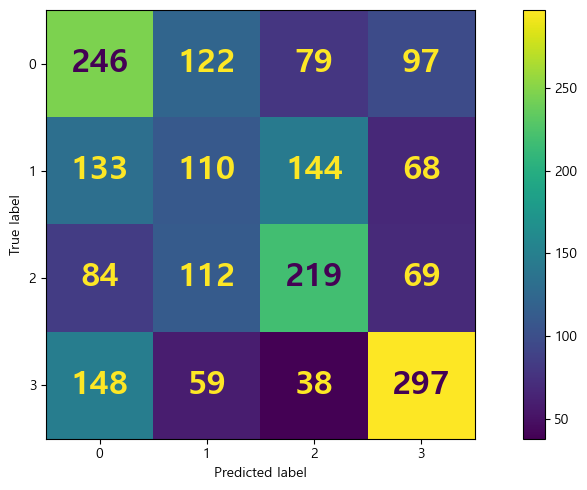


[Roc Curve]


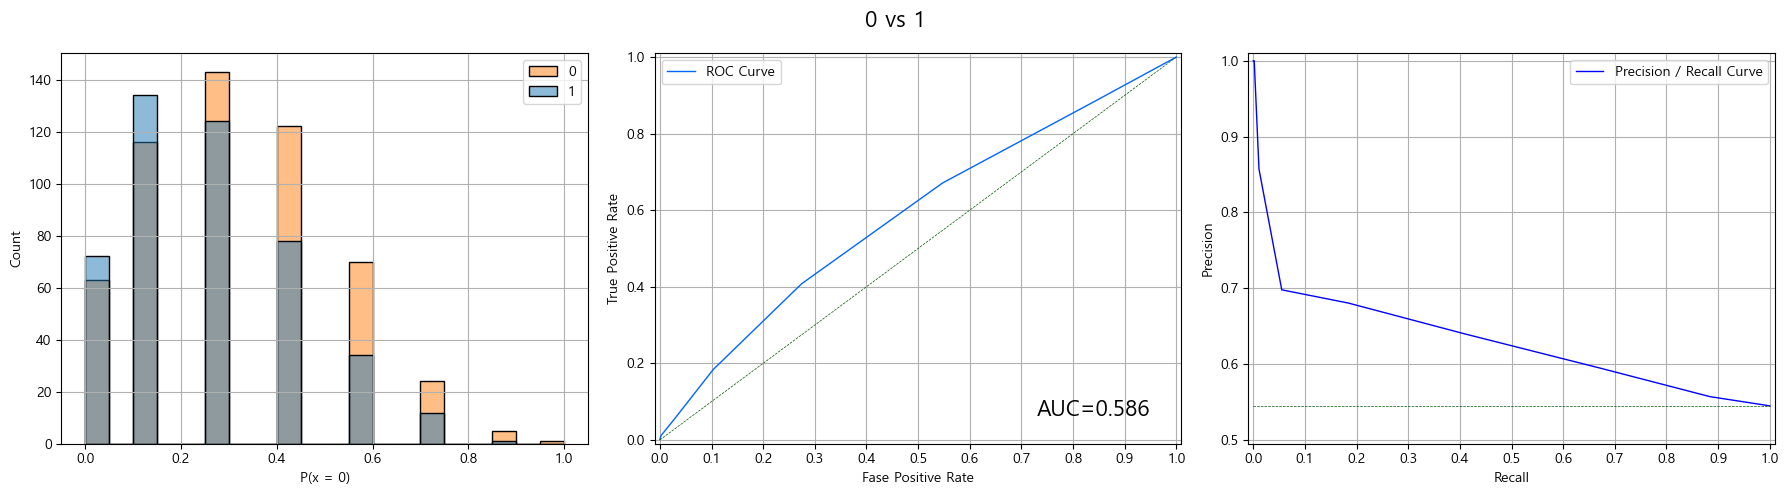

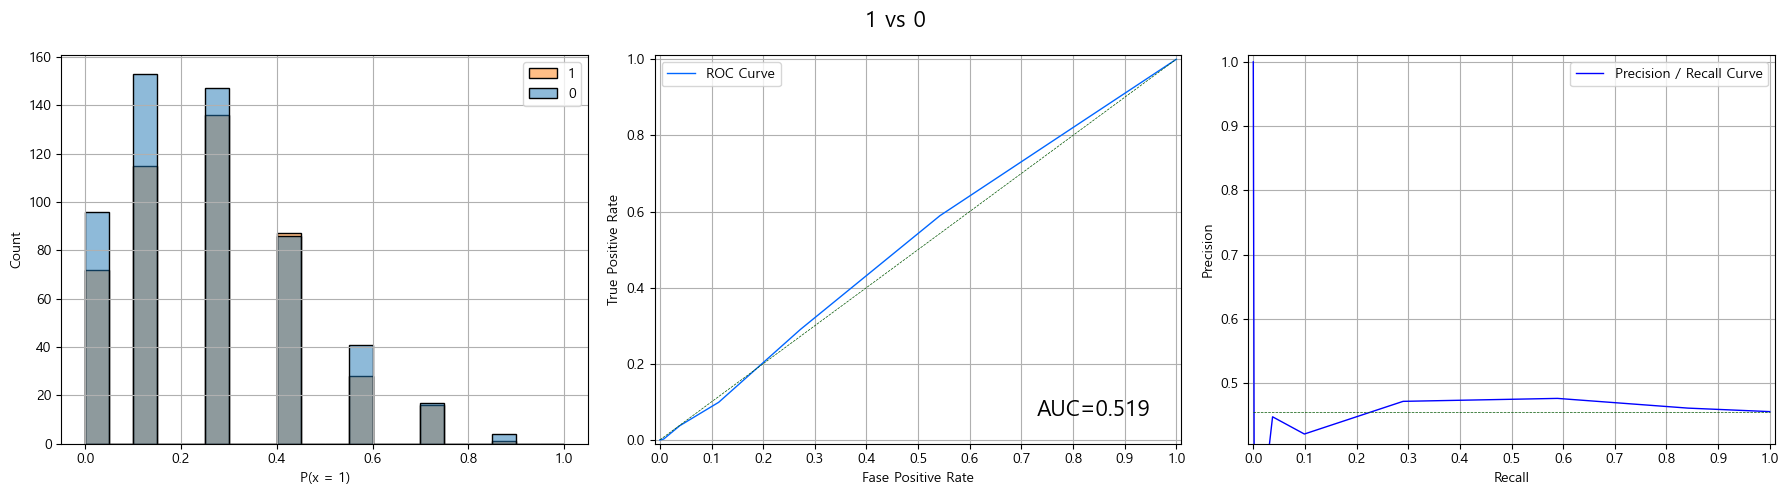

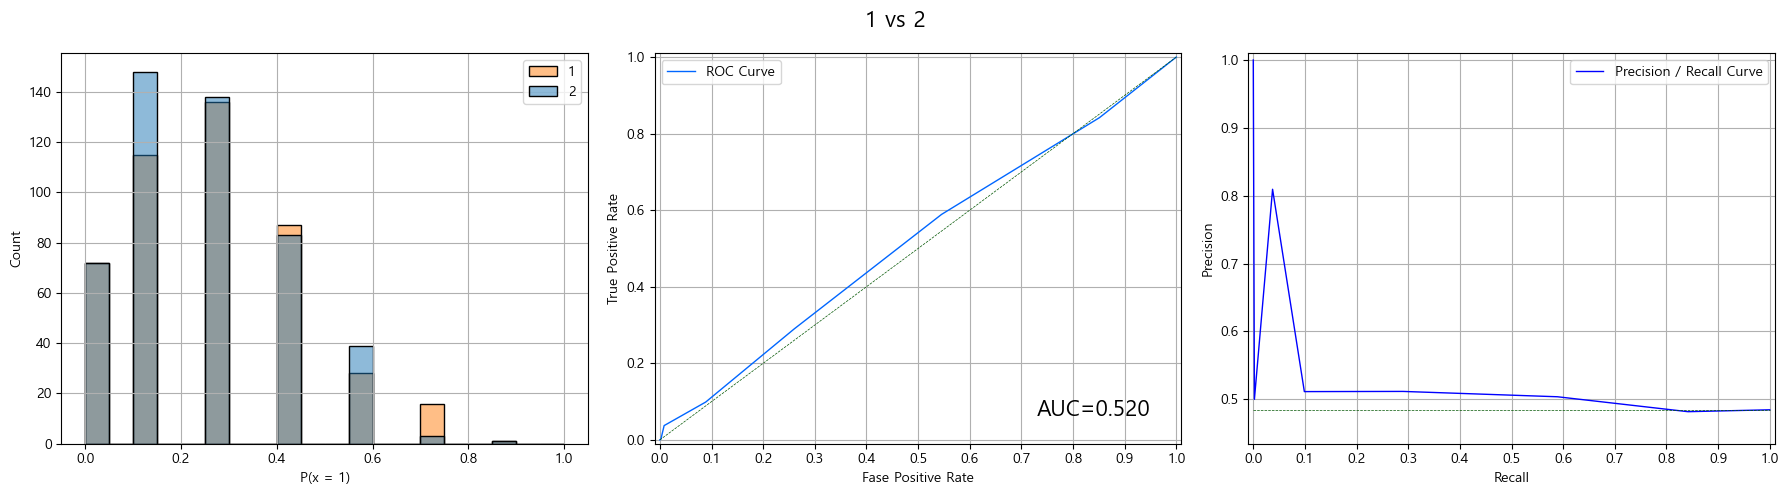

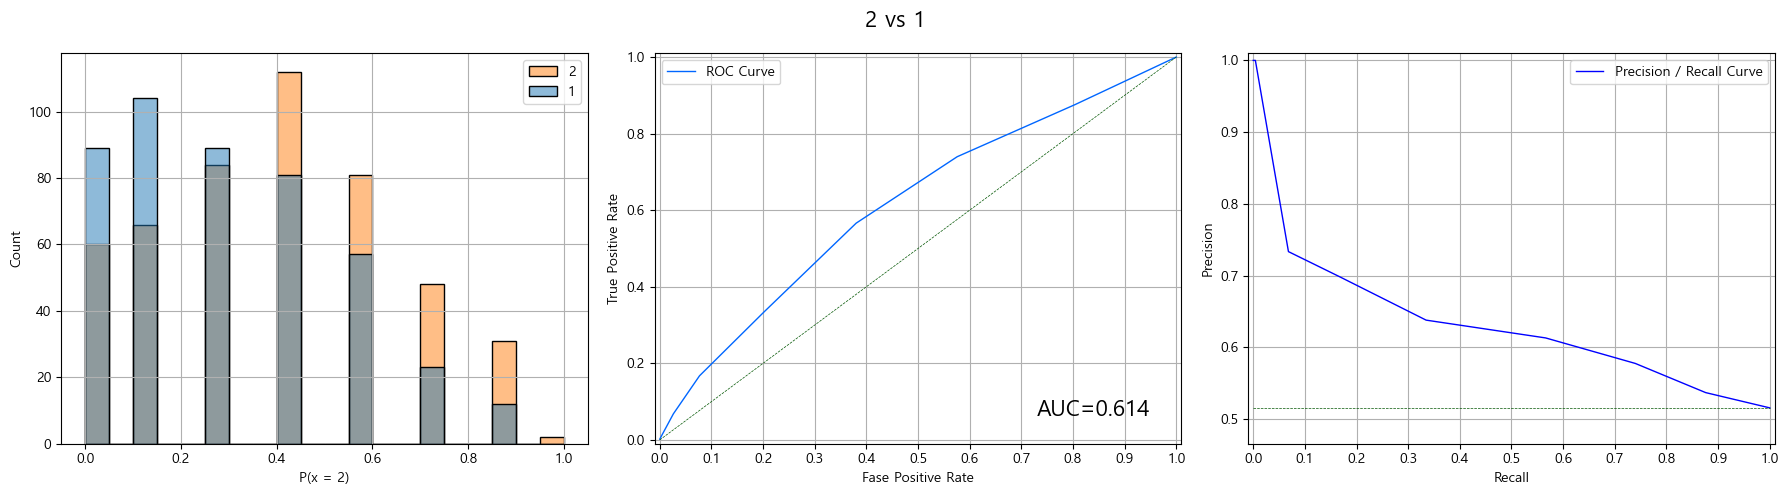

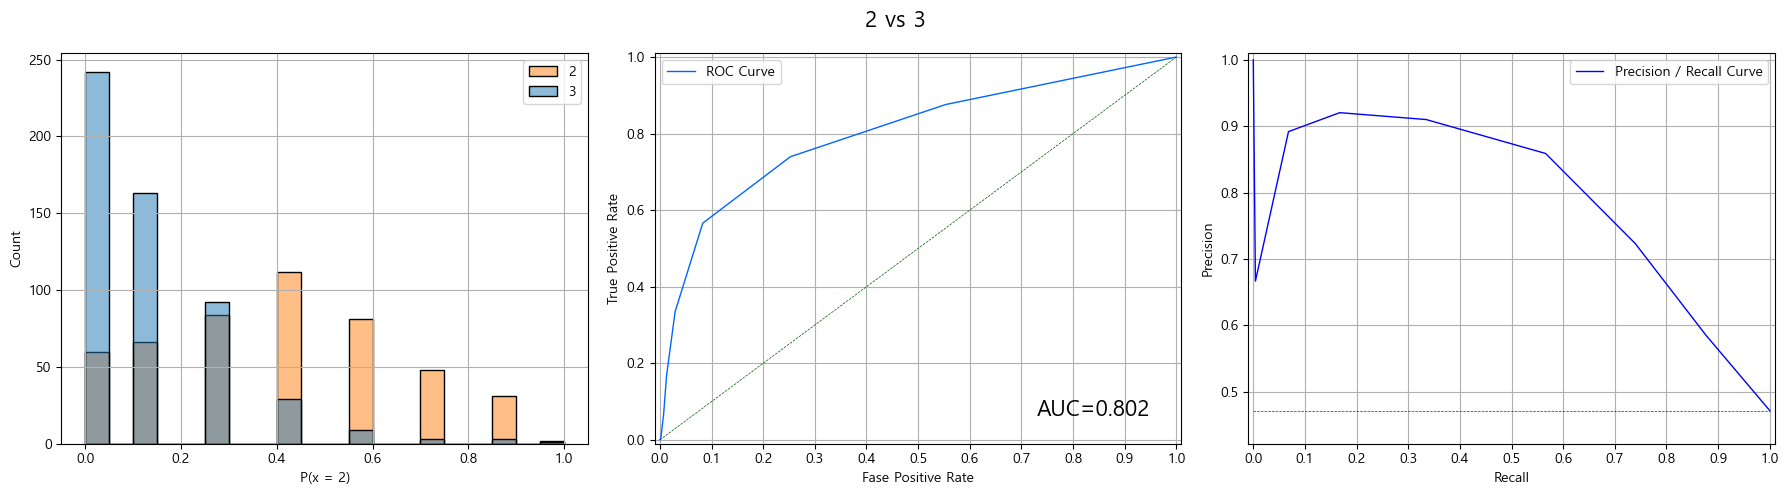

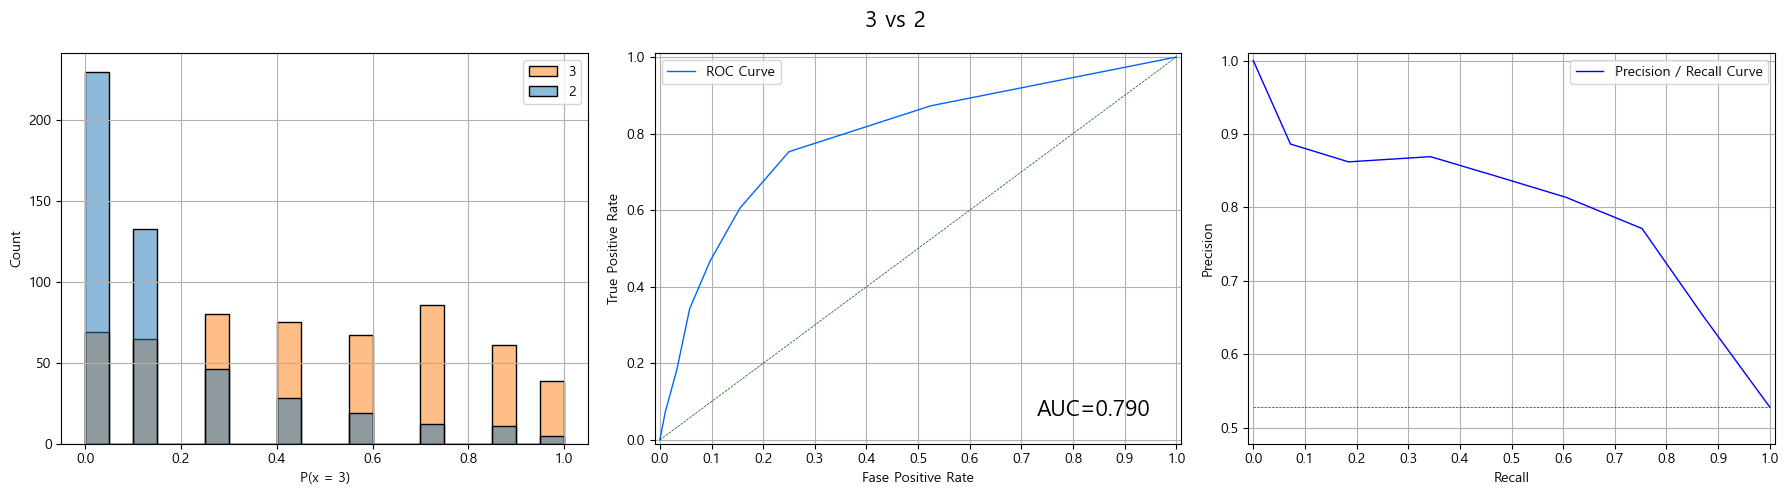

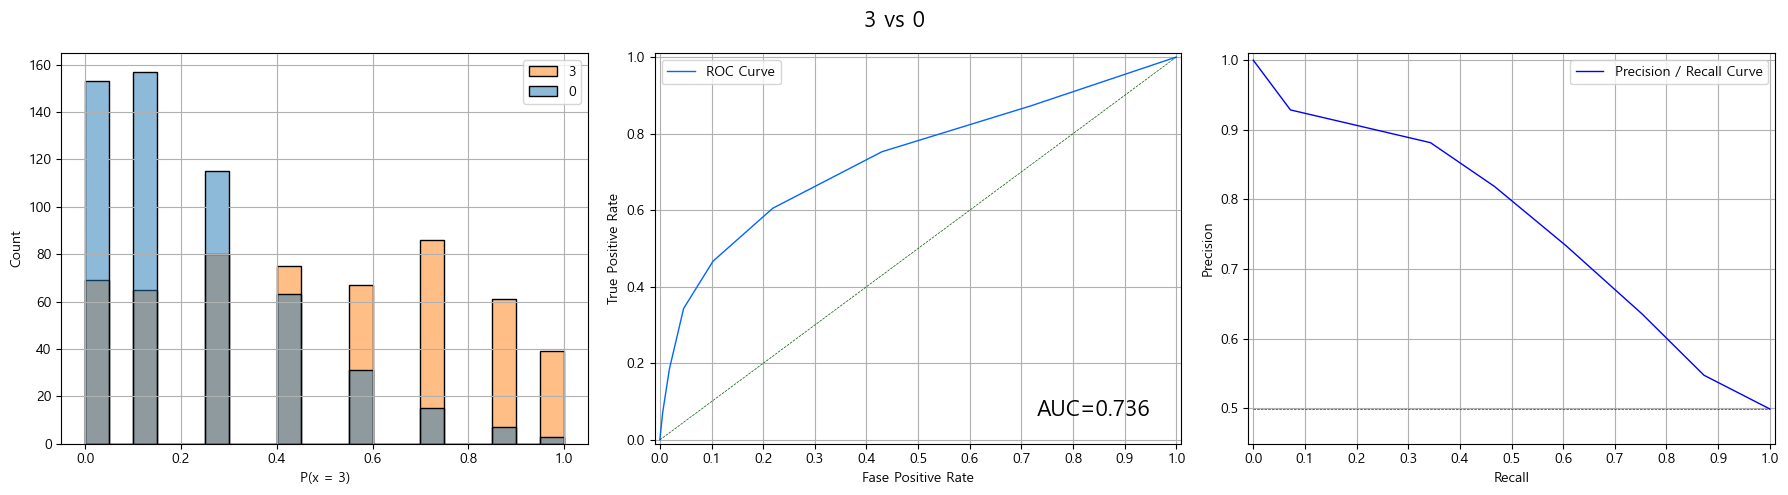

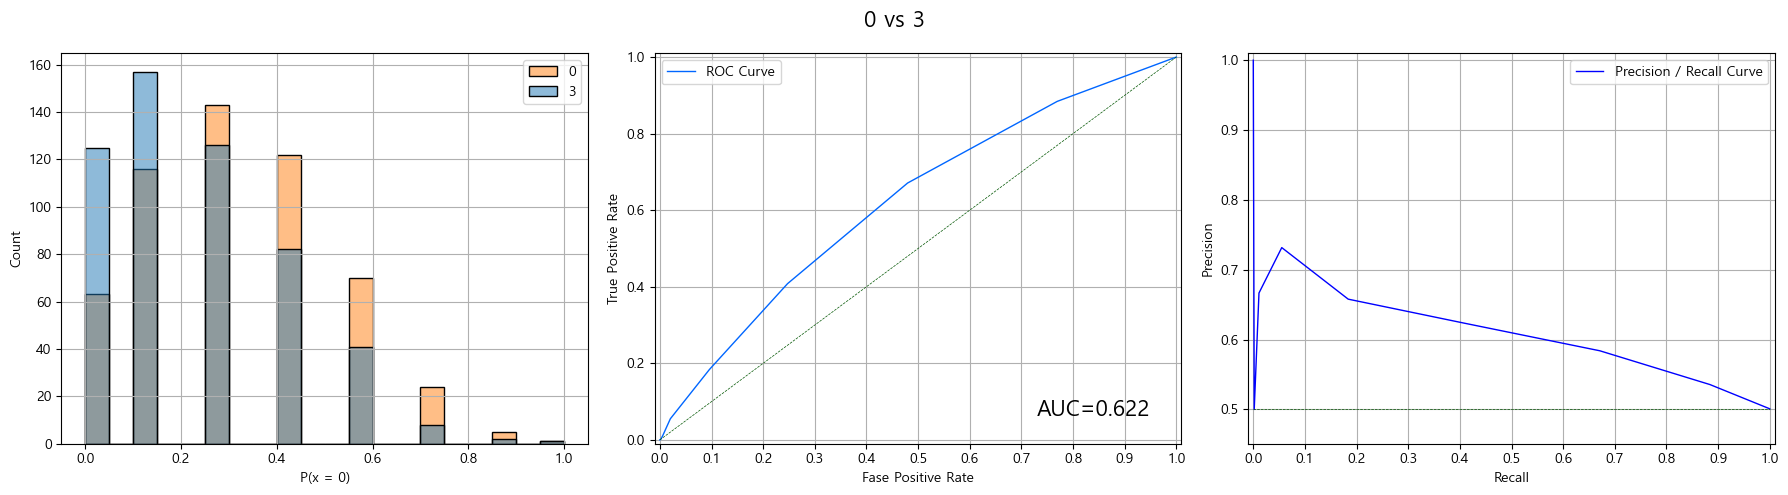

mean roc auc ovo: 0.6485

[학습곡선]


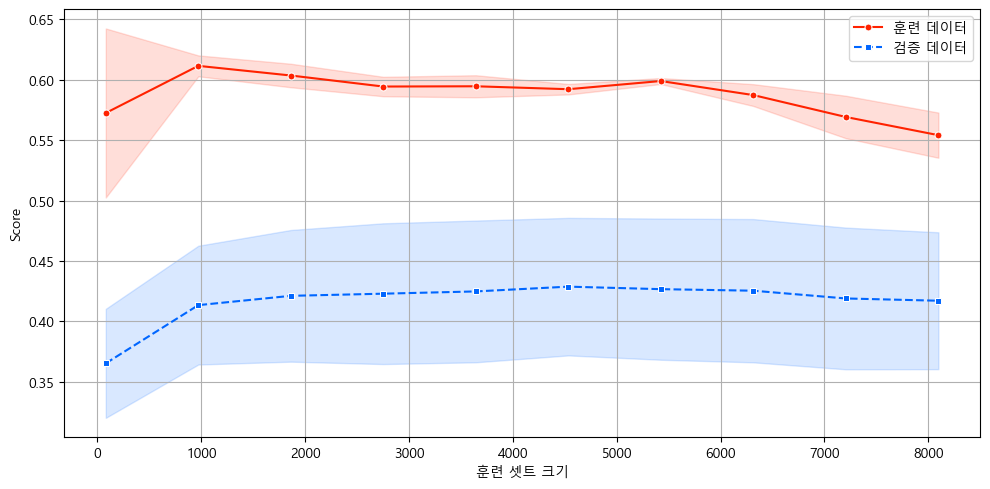

KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=7, p=1)

In [103]:
my_knn_classification(x_train, y_train, x_test, y_test)

> 파생변수를 추가했을 떄 정확도와 전체 지표가 조금 올라가기는 하지만 크게 올라가지는 않는다.

> 파생변수 추가 후 로지스틱분석과 KNN분석 결과는 다음과 같다.
>| 구분 | 로지스틱회귀 | KNN |
>|---|---|---|
>| 정확도 | 0.480494 | 0.430617 |
>| 정밀도 | 0.454953 | 0.422786 |
>| 재현율 | 0.469841 | 0.423603 |
>| F1 SCORE | 0.451052 | 0.422582 |
>| AUC | 0.728076 | 0.668471 |

> (파생변수 추가 전)
> | 구분 | 로지스틱회귀 | KNN |
>|---|---|---|
>| 정확도 | 0.48 | 0.425185 |
>| 정밀도 | 0.454 | 0.419 |
>| 재현율 | 0.469 | 0.418 |
>| F1 SCORE | 0.450 | 0.418 |
>| AUC | 0.727 | 0.662 |